<p align="center">
  <h1 align="center">MATH-600 Train Service Project</h1>
  <h3 align="center">Xu Chenghao,  
Delacroix Thomas Benoit,  
Zhang Ru,  
Cintas Albin Manuel  </h3>
</p>








----
# Section 0: Configuration
- Set the simulation clock and parameters like peak and off-peak demand rates, carriage capacities, and travel times between stations.
- Initialize the train schedule based on the given or proposed timetables.

**Library and Constant Definition**

In [2]:
import random
import numpy as np
import pandas as pd 
from datetime import timedelta, datetime
from math import floor, sin
from copy import deepcopy

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import matplotlib.dates as mdates 

np.random.seed(42)
random.seed(42)

In [3]:
TRAVEL_TIMES = [timedelta(minutes=40), # Geneva -> Lausanne
                timedelta(hours=1, minutes=10), # Lausanne -> Bern
                timedelta(hours=1)] # Bern -> Zurich
FIRST_CLASS_CAPACITY  = 300
SECOND_CLASS_CAPACITY = 500
STATIONS = [0, 1, 2, 3] # g, l, b, z

DEMAND_PEAKS = [[0, 1.5, 2.2, 1.3],
                [0, 0,   2.4, 1.1],
                [0, 0,   0,   3.3],
                [0, 0,   0,   0]] # 1000 passengers per hour

DEMAND_OFF_PEAKS = [[0, 0.4, 0.3, 0.5],
                    [0, 0,   0.5, 0.3],
                    [0, 0,   0,   0.5],
                    [0, 0,   0,   0]] # 1000 passengers per hour

FIRST_CLASS_PEAKS_PROPORTION = [[0, 0.13, 0.15, 0.17],
                                [0, 0,    0.21, 0.18],
                                [0, 0,    0,    0.32],
                                [0, 0,    0,    0]]

FIRST_CLASS_OFF_PEAKS_PROPORTION = [[0, 0.21, 0.18, 0.23],
                                    [0, 0,    0.24, 0.23],
                                    [0, 0,    0,    0.19],
                                    [0, 0,    0,    0]]

COST_TICKET_FIRST_CLASS      = 40 # per station per passenger
COST_TICKET_SECOND_CLASS     = 20 # per station per passenger

COST_EMPTY_SEAT_FIRST_CLASS  = 20 # per seat per station
COST_EMPTY_SEAT_SECOND_CLASS = 10 # per seat per station

COST_MISSING_FIRST_CLASS     = 30 # per passenger per station
COST_MISSING_SECOND_CLASS    = 10 # per passenger per station

# Define a one-day-long time sequences
T = datetime(2000, 1, 1, hour=0)
TIMESTAMPS = [T]
for i in range(24*60-1):
    T = T + timedelta(minutes=1)
    TIMESTAMPS.append(T)

# Section 1: Simulation

## Step 1: Define Simulation Components



- Stations: Geneva (G), Lausanne (L), Bern (B), Zurich (Z).  
(Each station should be reached in the following order)

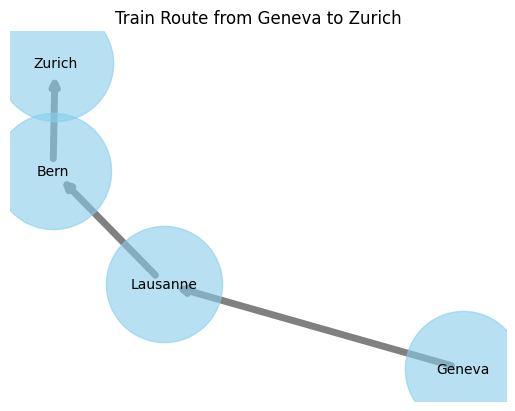

In [4]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes representing the stations
stations = ['Geneva', 'Lausanne', 'Bern', 'Zurich']
G.add_nodes_from(stations)

# Add edges representing the train routes
edges = [('Geneva', 'Lausanne'), ('Lausanne', 'Bern'), ('Bern', 'Zurich')]
G.add_edges_from(edges)

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=7000, node_color="skyblue", alpha=0.6)
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="gray", width=5, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.title("Train Route from Geneva to Zurich")
plt.axis('off')  # Turn off the axis
plt.show()


### Train class

- Trains: Model each train by its departure time, carriage composition (first and second class), and capacity.

In [5]:
class Train:
    """
    A class to represent a train.

    Attributes
    ----------
    depart_time : datetime
      the departure time of the train
    nb_first_class_carriage : int
      the number of first class carriages
    nb_second_class_carriage : int
      the number of second class carriages
    waiting_times : list
      the waiting times at each station ([Lausanne, Bern])
    travel_times : list
      the travel times between each station
    arrival_times : list
      the arrival times at each station
    departure_times : list
      the departure times at each station
    first_class_occupation : list
      the number of first class passengers in each carriage (at each station)
    full_first_class : list
      whether the first class carriages are full at each station (at each station)
    second_class_occupation : list
      the number of second class passengers in each carriage (at each station)
    full_second_class : list
      whether the second class carriages are full at each station (at each station)
    cost_empty_seat : float
      the cost of empty seats in the train for the company
    """
    def __init__(self,
               depart_time:datetime,
               nb_first_class_carriage:int,
               nb_second_class_carriage:int,
               waiting_times = [timedelta(0), timedelta(0)],
               travel_times: list = TRAVEL_TIMES):
        # problem constraint, no trains of more than 150m     
        assert nb_first_class_carriage + nb_second_class_carriage <= int(150/25)
    
        self.depart_time = depart_time
        self.waiting_times = waiting_times #[Geneva, Lausanne, Bern]
        self.travel_times = travel_times

        self.define_arrival_times()   #[Geneva, Lausanne, Bern, Zurich]
        self.define_departure_times() #[Geneva, Lausanne, Bern]

        self.nb_first_class_carriage = nb_first_class_carriage
        self.first_class_occupation = [0,0,0] #[G-L, L-B, B-Z]
        self.full_first_class = [False, False, False]

        self.nb_second_class_carriage = nb_second_class_carriage
        self.second_class_occupation = [0,0,0] #[G-L, L-B, B-Z]
        self.full_second_class = [False, False, False]

#         self.cost_empty_seat = self.define_cost_empty_seats(COST_EMPTY_SEAT_FIRST_CLASS, 
#                                                             COST_EMPTY_SEAT_SECOND_CLASS, 
#                                                             FIRST_CLASS_CAPACITY, 
#                                                             SECOND_CLASS_CAPACITY)

    def first_class_passenger_enters(self, station:int):
        # Increment the number of first class passengers in the train   
        self.first_class_occupation[station:] = [x+1 for x in self.first_class_occupation[station:]]
        if self.first_class_occupation[station] == FIRST_CLASS_CAPACITY * self.nb_first_class_carriage:
            self.full_first_class[station] = True

    def first_class_passenger_leaves(self, station:int):
        # Decrement the number of first class passengers in the train
        self.first_class_occupation[station:] = [x-1 for x in self.first_class_occupation[station:]]
        if self.full_first_class[station]:
            self.full_first_class[station] = False

    def second_class_passenger_enters(self, station:int):
        # Increment the number of second class passengers in the train
        self.second_class_occupation[station:] = [x+1 for x in self.second_class_occupation[station:]]
        if self.second_class_occupation[station] == SECOND_CLASS_CAPACITY * self.nb_second_class_carriage:
            self.full_second_class[station] = True

    def second_class_passenger_leaves(self, station:int):
        # Decrement the number of second class passengers in the train
        self.second_class_occupation[station:] = [x-1 for x in self.second_class_occupation[station:]]
        if self.full_second_class[station]:
            self.full_second_class[station] = False

    def define_waiting_times(self, station:int, hour:datetime):
        # Define the waiting time at a station of the train
        self.waiting_times[station] = hour
        self.define_arrival_times()

    def define_arrival_times(self):
        # Define the arrival times at each station
        self.arrival_times = [self.depart_time, 
                      self.depart_time + self.travel_times[0], 
                      self.depart_time + self.travel_times[0] + self.waiting_times[0] + self.travel_times[1],
                      self.depart_time + self.travel_times[0] + self.waiting_times[0] + self.travel_times[1] + self.waiting_times[1] + self.travel_times[2]]

    def define_departure_times(self):
        # Define the departure times from each station
        self.departure_times = [self.depart_time,
                                self.depart_time + self.travel_times[0] + self.waiting_times[0],
                                self.depart_time + self.travel_times[0] + self.waiting_times[0] + self.travel_times[1] + self.waiting_times[1]]


    def define_cost_empty_seats(self, cost_first_class      = COST_EMPTY_SEAT_FIRST_CLASS, 
                                      cost_second_class     = COST_EMPTY_SEAT_SECOND_CLASS,
                                      capacity_first_class  = FIRST_CLASS_CAPACITY,
                                      capacity_second_class = SECOND_CLASS_CAPACITY):
        # Define the cost of empty seats in the train for the company
        return np.sum(self.nb_second_class_carriage * capacity_second_class - np.array(self.second_class_occupation)) * cost_second_class \
             + np.sum(self.nb_first_class_carriage  * capacity_first_class  - np.array(self.first_class_occupation))  * cost_first_class

### Passenger class

- Passengers: Generate passengers based on the demand matrix, with attributes for origin, destination, class, and arrival time at the station.

In [6]:
class Passenger:
    """
    A class to represent a passenger.
    
    Attributes
    ----------
    origin : str
        the origin station of the passenger
    destination : str
        the destination station of the passenger
    first_second_class : bool
        whether the passenger is in first or second class
    ticket_price : float
        the price of the ticket
    arrival_time : datetime
        the arrival time of the passenger at the origin station
    embarked_time : datetime
        the time at which the passenger embarked on the train
    waiting_time : timedelta
        the waiting time of the passenger
    arrived : bool
        whether the passenger arrived at the destination
    train_missed_full : int
        the number of trains on which the passenger cannot enter because it is full
    """
    def __init__(self, 
                 origin:str,
                 destination:str,
                 first_second_class:bool):
        # static properties
        self.origin = origin
        self.destination = destination
        self.first_second_class = first_second_class
        self.ticket_price = self.define_ticket_price()
        self.arrival_time = None

        # dynamic properties
        self.embarked_time = None
        self.waiting_time = timedelta(0)
        self.arrived = False

        self.train_missed_full = 0 # the number of trains on which the passenger cannot enter because it is full
    
    def define_ticket_price(self):
        if self.first_second_class:
            return COST_TICKET_FIRST_CLASS  * (int(self.destination) - int(self.origin))
        else :
            return COST_TICKET_SECOND_CLASS * (int(self.destination) - int(self.origin))
    
    def define_arrival_time(self, arrival_time:datetime):
        self.arrival_time  = arrival_time
        self.waiting_time = TIMESTAMPS[-1] - self.arrival_time
  
    def define_embarked_time(self, embarked_time:datetime):
        self.embarked_time = embarked_time
        self.waiting_time  = self.embarked_time - self.arrival_time

    def set_arrival(self):
        self.arrived= True

## Step 2: Define Passenger Arrival Distribution
- Simulate passenger arrivals at each station using the demand rates. Use different rates for peak and off-peak periods.
- Assign passengers to first or second class based on the proportions given.

In [7]:
@staticmethod
def peak_hour(time):
    """
    Check if the time is in peak hours.
    """
    PEAK_HOURS = [(datetime(2000, 1, 1, hour=7),  datetime(2000, 1, 1, hour=9)),
                  (datetime(2000, 1, 1, hour=16), datetime(2000, 1, 1, hour=18))]
    
    for peak_hour in PEAK_HOURS:
        if time >= peak_hour[0] and time <= peak_hour[1]:
            return True
    return False

@staticmethod
def arrival_rate(time):
    """
    Calculate the arrival rate of passengers no matter the station, depending on the time. 
    """
    # Define arrvied passengers for peaked hours
    demand_peak_first  = 1000 * np.multiply(np.array(DEMAND_PEAKS), np.array(FIRST_CLASS_PEAKS_PROPORTION))
    demand_peak_second = 1000 * np.array(DEMAND_PEAKS) - demand_peak_first
    
    # Define arrvied passengers for off-peaked hours
    demand_off_peak_first  = 1000 * np.multiply(np.array(DEMAND_OFF_PEAKS), np.array(FIRST_CLASS_OFF_PEAKS_PROPORTION))
    demand_off_peak_second = 1000 * np.array(DEMAND_OFF_PEAKS) - demand_off_peak_first
    
    if peak_hour(time):
        first_arrival_rate  = demand_peak_first / 60.0
        second_arrival_rate = demand_peak_second / 60.0
    else:
        first_arrival_rate  = demand_off_peak_first / 60.0
        second_arrival_rate = demand_off_peak_second / 60.0 
    
    return first_arrival_rate, second_arrival_rate

@staticmethod
def create_new_passengers(arrivers, arrival_time, first_class=True):
    passengers = []
    for x in range(4):
        for y in range(4):
            if arrivers[x][y] != 0:
                for i in range(arrivers[x][y]):
                    passenger = Passenger(x, y, first_class)
                    passenger.define_arrival_time(arrival_time)
                    passengers.append(passenger)
    return passengers

In [8]:
def constant_passenger_arrivals():
    """
    Define a strategy of constant passenger arrivals. It respects the matrixes from the problem and ensures that the passenger rate is constant during peak and off-peak hours
    """
    
    # Define all new arrivals
    all_first_passengers  = [np.zeros((4,4))]
    all_second_passengers = [np.zeros((4,4))]
    
    accum_first_passengers  = np.zeros((4,4))
    accum_second_passengers = np.zeros((4,4))
    
    for t in TIMESTAMPS:
        # Calculate arrival rate based on time
        first_passengers_rate, second_passengers_rate = arrival_rate(t)
        accum_first_passengers  += first_passengers_rate  # accumualted first-class passengers
        accum_second_passengers += second_passengers_rate # accumulated second-class passengers
        
        # Accumulating Passengers based on interger
        all_first_passengers.append((np.floor(accum_first_passengers)))
        all_second_passengers.append((np.floor(accum_second_passengers)))
    
    # Calculate arrivers (as Integer)
    new_first_arrivers_list  = np.diff(np.array(all_first_passengers).astype(int),  axis=0)
    new_second_arrivers_list = np.diff(np.array(all_second_passengers).astype(int), axis=0)

    all_passengers = []
    
    assert(len(new_first_arrivers_list)==len(TIMESTAMPS))
           
    for idx, t in enumerate(TIMESTAMPS):
        new_first_arrivers  = new_first_arrivers_list[idx]
        all_passengers.extend(create_new_passengers(new_first_arrivers, t, True))
        
        new_second_arrivers = new_second_arrivers_list[idx]
        all_passengers.extend(create_new_passengers(new_second_arrivers, t, False))
    
    return all_passengers

def poisson_passenger_arrivals():
    all_passengers = []
    
    for t in TIMESTAMPS:
        # Calculate arrival rate based on time
        first_passengers_rate, second_passengers_rate = arrival_rate(t)
        
        for x in range(4):
            for y in range(4):
                if first_passengers_rate[x][y] != 0:
                    num_first_arrivers = np.random.poisson(lam = first_passengers_rate[x][y])
                    for i in range(num_first_arrivers):
                        passenger = Passenger(x, y, True)
                        passenger.define_arrival_time(t)
                        all_passengers.append(passenger)
                        
                if second_passengers_rate[x][y] != 0:
                    num_second_arrivers = np.random.poisson(lam = second_passengers_rate[x][y])
                    for i in range(num_second_arrivers):
                        passenger = Passenger(x, y, False)
                        passenger.define_arrival_time(t)
                        all_passengers.append(passenger)
                    
    return all_passengers

#### Plot of the Constant / Poisson Distributed Passenger Arrivals Strategy

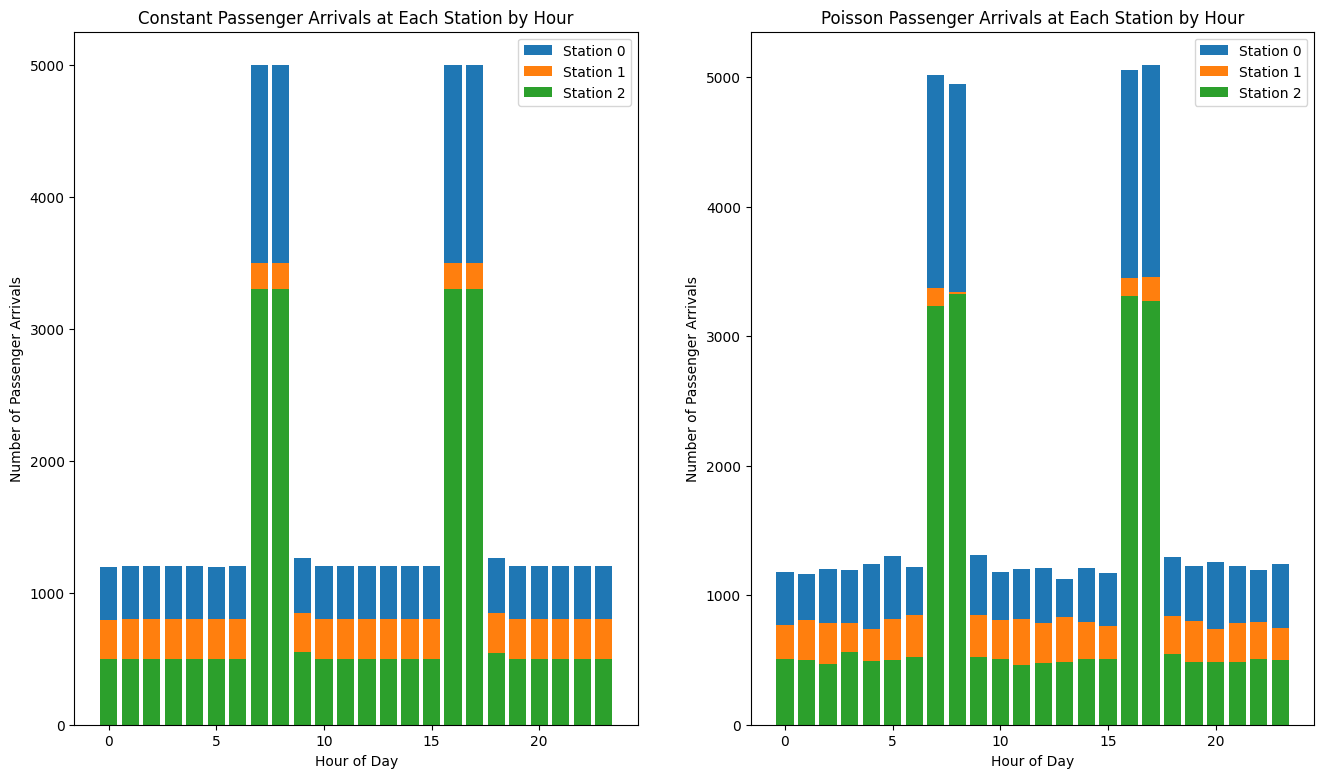

In [9]:
plt.figure(figsize=(16, 9))

plt.subplot(1,2,1)
all_passengers_cst = constant_passenger_arrivals()

# Initialize a dictionary to hold the count of arrivals per station per hour
arrivals_per_hour_per_station = {0: [0]*24, 1: [0]*24, 2: [0]*24}

# Iterate over passenger objects to fill the dictionary
for passenger in all_passengers_cst:
    hour_of_arrival = passenger.arrival_time.hour  # Assuming this is a datetime object
    station = int(passenger.origin)  # Assuming 'origin' is the station where they arrive (converted to int)
    arrivals_per_hour_per_station[station][hour_of_arrival] += 1

# Now, plot the data
hours = list(range(24))  # 0 to 23 hours
for station in arrivals_per_hour_per_station:
    plt.bar(hours, arrivals_per_hour_per_station[station], label=f'Station {station}')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Passenger Arrivals')
plt.title('Constant Passenger Arrivals at Each Station by Hour')
plt.legend()
    

plt.subplot(1,2,2)
all_passengers_poisson = poisson_passenger_arrivals()

# Initialize a dictionary to hold the count of arrivals per station per hour
arrivals_per_hour_per_station = {0: [0]*24, 1: [0]*24, 2: [0]*24}

# Iterate over passenger objects to fill the dictionary
for passenger in all_passengers_poisson:
    hour_of_arrival = passenger.arrival_time.hour  # Assuming this is a datetime object
    station = int(passenger.origin)  # Assuming 'origin' is the station where they arrive (converted to int)
    arrivals_per_hour_per_station[station][hour_of_arrival] += 1

# Now, plot the data
hours = list(range(24))  # 0 to 23 hours
for station in arrivals_per_hour_per_station:
    plt.bar(hours, arrivals_per_hour_per_station[station], label=f'Station {station}')

plt.xlabel('Hour of Day')
plt.ylabel('Number of Passenger Arrivals')
plt.title('Poisson Passenger Arrivals at Each Station by Hour')
plt.legend()
plt.show()


# Step 3: Train Operation
- For each train departure, calculate the available capacity by carriage type and board passengers accordingly.
- Implement a "first-come-first-serve" boarding logic, ensuring passengers board the correct class and handle cases where passengers need to wait for the next train.
- Keep track of metrics like the number of passengers missing trains and the number of empty seats.

In [10]:
def trains_passengers_management(all_passengers, all_trains, stations=STATIONS):
    all_passengers = sorted(all_passengers, key = lambda x:x.arrival_time)
    all_trains = sorted(all_trains, key=lambda x: x.depart_time)
    
    # Preprocess passengers by origin and destination for quick lookup
    passengers_by_origin = {}
    passengers_by_destination = {}
    
    for passenger in all_passengers:
        if passenger.origin not in passengers_by_origin:
            passengers_by_origin[passenger.origin] = []
        passengers_by_origin[passenger.origin].append(passenger)
        
        if passenger.destination not in passengers_by_destination:
            passengers_by_destination[passenger.destination] = []
        passengers_by_destination[passenger.destination].append(passenger)
        
    # Iterate through each train
    for train in all_trains:
        # Check for every station except Zurich (the terminus)
        for station in stations[:-1]:
            # Process passengers leaving the train
            if station in passengers_by_destination:
                for passenger in passengers_by_destination[station]:
                    if passenger.embarked_time and not passenger.arrived:
                        if passenger.first_second_class:
                            train.first_class_passenger_leaves(station)
                        else:
                            train.second_class_passenger_leaves(station)
                        passenger.set_arrival()

            # Process passengers boarding the train
            if station in passengers_by_origin:
                for passenger in passengers_by_origin[station]:
                    if passenger.embarked_time is None and passenger.arrival_time < train.departure_times[station]:
                        if passenger.first_second_class and not train.full_first_class[station]:
                            train.first_class_passenger_enters(station)
                            passenger.define_embarked_time(max(passenger.arrival_time, train.arrival_times[station]))
                        elif not passenger.first_second_class and not train.full_second_class[station]:
                            train.second_class_passenger_enters(station)
                            passenger.define_embarked_time(max(passenger.arrival_time, train.arrival_times[station]))
                        else:
                            passenger.train_missed_full += 1

# Step 4: Simulation Scenarios


### Scenario 1 :
- Constant interval **every 20 minutes** between each train all day long.
- Each train is composed of **3 second-class carriages** and **1 first-class carriage**.
- Constant waiting times of **5 minutes** in Lausanne and Bern for every train.

In [11]:
def constant_simple_trains():
    beginning_day = datetime(2000, 1, 1, hour=0) 
    end_day = datetime(2000, 1, 2, hour=0) 
    freq = timedelta(minutes=20)
    
    date_range = pd.date_range(start=beginning_day, end=end_day, freq=freq, inclusive='left').tolist() # generation of departure dates for each train
    all_trains = []
    for date in date_range:
        new_train = Train(date, 1, 3, [timedelta(minutes=5), timedelta(minutes=5)]) # new instance 
        all_trains.append(new_train)
    all_trains = sorted(all_trains, key=lambda x: x.depart_time)
    return all_trains, date_range

### Scenario 2 :
- Constant departure rate (**every 15 minitues**) between every train during peak hours, other constant rate (**every 30 minutes**) during off-peak hours.
- Each train is composed of **3 second-class carriages** and **1 first-class carriage**.
- Constant waiting times of **5 minutes** in Lausanne and Bern for every train.

In [12]:
def constant_during_peaks_trains():
    dates_define_peaks = [datetime(2000, 1, 1, hour=0), 
            datetime(2000, 1, 1, hour=7),
            datetime(2000, 1, 1, hour=9),
            datetime(2000, 1, 1, hour=16),
            datetime(2000, 1, 1, hour=18),
            datetime(2000, 1, 2, hour=0)]
    
    date_range = [] # list containing all the departs 
    date_range += pd.date_range(start=dates_define_peaks[0], end=dates_define_peaks[1],
                                freq=timedelta(minutes=30), inclusive='left').tolist() 
    date_range += pd.date_range(start=dates_define_peaks[1], end=dates_define_peaks[2],
                                freq=timedelta(minutes=15), inclusive='left').tolist() 
    date_range += pd.date_range(start=dates_define_peaks[2], end=dates_define_peaks[3],
                                freq=timedelta(minutes=30), inclusive='left').tolist() 
    date_range += pd.date_range(start=dates_define_peaks[3], end=dates_define_peaks[4],
                                freq=timedelta(minutes=15), inclusive='left').tolist() 
    date_range += pd.date_range(start=dates_define_peaks[4], end=dates_define_peaks[5],
                                freq=timedelta(minutes=30), inclusive='left').tolist() 
    
    all_trains = []
    for date in date_range:
        new_train = Train(date, 1, 3, [timedelta(minutes=5), timedelta(minutes=5)]) # new instance 
        all_trains.append(new_train)
    all_trains = sorted(all_trains, key=lambda x: x.depart_time)
    return all_trains, date_range

### Scenario 3 :
- Constant interval **every 20 minutes** for each train's departure all day long
- Each train is composed of **2 second-class carriages** and **1 first-class carriage** during off-peak hours, **4 second-class carriages** and **2 first-class carriages** during peak hours.
- Constant waiting times of **5 minutes** in Lausanne and Bern for every train.

In [13]:
def constant_depart_nb_carriages_change(): 
    beginning_day = datetime(2000, 1, 1, hour=0) 
    end_day = datetime(2000, 1, 2, hour=0) 
    freq = timedelta(minutes=20)
    
    date_range = pd.date_range(start=beginning_day, end=end_day, freq=freq, inclusive='left').tolist() # generation of departure dates for each train
    
    all_trains = []
    for date in date_range:
        if peak_hour(date): # if peaks
            new_train = Train(date, 2, 4, [timedelta(minutes=5), timedelta(minutes=5)]) 
        else:
            new_train = Train(date, 1, 2, [timedelta(minutes=5), timedelta(minutes=5)])
        all_trains.append(new_train)

    all_trains = sorted(all_trains, key=lambda x: x.depart_time)
    return all_trains, date_range

### Scenario 4 :
- Constant departure rate (**every 15 minitues**) between every train during peak hours, other constant rate (**every 20 minutes**) during off-peak hours.
- Each train is composed of **2 second class-carriages** and **1 first-class carriage** during off-peak hours, **4 second-class carriages** and **2 first-class carriages** during peak hours.
- Constant waiting times of **5 minutes** in Lausanne and Bern for every train.

In [14]:
def different_rates_and_carriages():
    dates_define_peaks = [datetime(2000, 1, 1, hour=0), 
            datetime(2000, 1, 1, hour=7),
            datetime(2000, 1, 1, hour=9),
            datetime(2000, 1, 1, hour=16),
            datetime(2000, 1, 1, hour=18),
            datetime(2000, 1, 2, hour=0)]
    
    date_range = [] # list containing all the departs 
    date_range += pd.date_range(start=dates_define_peaks[0], end=dates_define_peaks[1],
                                freq=timedelta(minutes=20), inclusive='left').tolist() 
    date_range += pd.date_range(start=dates_define_peaks[1], end=dates_define_peaks[2],
                                freq=timedelta(minutes=15), inclusive='left').tolist() 
    date_range += pd.date_range(start=dates_define_peaks[2], end=dates_define_peaks[3],
                                freq=timedelta(minutes=20), inclusive='left').tolist() 
    date_range += pd.date_range(start=dates_define_peaks[3], end=dates_define_peaks[4],
                                freq=timedelta(minutes=15), inclusive='left').tolist() 
    date_range += pd.date_range(start=dates_define_peaks[4], end=dates_define_peaks[5],
                                freq=timedelta(minutes=20), inclusive='left').tolist() 
    
    all_trains = []
    for date in date_range:
        if peak_hour(date):
            new_train = Train(date, 2, 4, [timedelta(minutes=5), timedelta(minutes=5)]) # new instance
        else:
            new_train = Train(date, 1, 2, [timedelta(minutes=5), timedelta(minutes=5)]) # new instance
        all_trains.append(new_train)
    all_trains = sorted(all_trains, key=lambda x: x.depart_time)
    return all_trains, date_range

### Scenario 5 :
- Train departures are defined by a **Non-Homogeneous Poisson Process** with $\lambda$ defined as
$\lambda(t) = \begin{cases} 4, \text{ if } t \in \text{ peakhours, } \\ 
    2, \text{ otherwise } \end{cases}$
- Each train is composed of **3 second-class carriages** and **1 first-class carriage**.
- Constant waiting times of **5 minutes** in Lausanne and Bern for every train.

In [15]:
def lam(time):
    if peak_hour(time):
        return 4
    else:
        return 2

def non_homogeneous_train_departures(lam=lam, lam_max=4, duration=24):
    nb_first_carriages  = 1
    nb_second_carriages = 3
    
    SIMULATION_FLAG = True
    while SIMULATION_FLAG:
        t = 0
        date_range = []
        all_trains = []
        
        while t < duration:
            delta_time = -np.log(np.random.uniform(0,1))/lam_max
            if delta_time >= 1.0: continue # CONSTRAINT 1

            t = t + delta_time
            departure_time = TIMESTAMPS[0] + timedelta(hours=t)

            s = np.random.uniform(0, 1) 
            if s <= lam(departure_time)/lam_max and t <= duration:                
                date_range.append(departure_time)
                new_train = Train(departure_time, nb_first_carriages, nb_second_carriages, [timedelta(minutes=5), timedelta(minutes=5)])
                all_trains.append(new_train)
        
        # Check if the distribution follows the CONSTRAINT 1:
        # The interval between two trains should less than 1 hour
        for i in range(len(date_range)-1):
            if date_range[i+1] - date_range[i] > timedelta(hours=1.0):
                SIMULATION_FLAG = True
                break
            SIMULATION_FLAG = False
    
    return all_trains, date_range

# Step 5: Analysis

#### Scenario of interest:

In [16]:
def Scenario(SCENARIO_OF_INTEREST:int, Poisson_Passengers:True):
    if Poisson_Passengers:
        all_passengers = poisson_passenger_arrivals()
    else:
        all_passengers = constant_passenger_arrivals()
    
    if SCENARIO_OF_INTEREST   == 1: # Every 20 miniutes. Each with 1 first-class and 3 second-class carriages.
        all_trains, date_range = constant_simple_trains()
    elif SCENARIO_OF_INTEREST == 2: # Peak/OffPeak every 15/30 miniutes. Each with 1 first-class and 3 second-class carriages.
        all_trains, date_range = constant_during_peaks_trains()
    elif SCENARIO_OF_INTEREST == 3: # Every 20 miniutes. Peak/Off with 2/1 first-class and 4/2 second-class carriages.
        all_trains, date_range = constant_depart_nb_carriages_change()
    elif SCENARIO_OF_INTEREST == 4: # Peak/OffPeak every 15/20 miniutes. Peak/Off with 2/1 first-class and 4/2 second-class carriages.
        all_trains, date_range = different_rates_and_carriages()
    elif SCENARIO_OF_INTEREST == 5: # Non-homogeneous Departure. Each with 1 first-class and 3 second-class carriages.
        all_trains, date_range = non_homogeneous_train_departures()
    else:
        raise AssertionError("False Input for SCENARIOS_OF_INTEREST")
        
    trains_passengers_management(all_passengers, all_trains)
    all_trains     = sorted(all_trains, key=lambda x: x.depart_time)
    all_passengers = sorted(all_passengers, key=lambda x: x.arrival_time)
    return all_trains, all_passengers

In [17]:
SCENARIO_OF_INTEREST = 4 # select from [1-5]
all_trains, all_passengers = Scenario(SCENARIO_OF_INTEREST, False)

## Train Timelines 
Each point in the arrival or the departure of a train and the lines represent the route between two consecutive stations for a train.

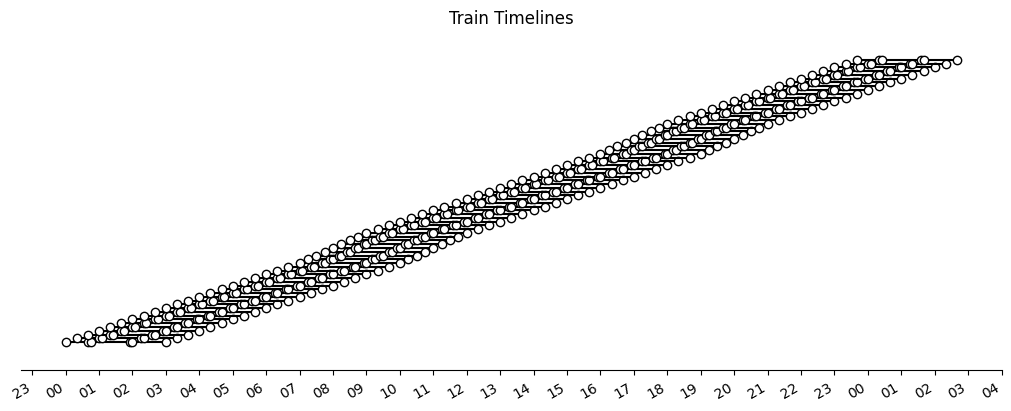

In [18]:
def plot_train_timelines(all_trains, all_passengers):
    all_trains = sorted(all_trains, key=lambda x: x.depart_time)
    # plot the timeline for every train 
    fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")
    ax.set(title="Train Timelines")

    id_train= 0
    for train in all_trains:
        id_train += 1
        dates = [train.departure_times[0], train.arrival_times[1],
                 train.departure_times[1], train.arrival_times[2],
                 train.departure_times[2], train.arrival_times[3]]
        ax.plot(dates, [id_train, id_train, id_train, id_train, id_train, id_train], "-o",
                color="k", markerfacecolor="w")  # Baseline and markers on it.

    # format x-axis with 4-month intervals
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y-axis and spines
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)

    ax.margins(y=0.1)
    plt.show()

plot_train_timelines(all_trains, all_passengers)

## First-Class Occupation of Each Train 
Each train is represented by a color. The x-axis represents the time of the day and the y-axis represents the occupation of the first class carriages.

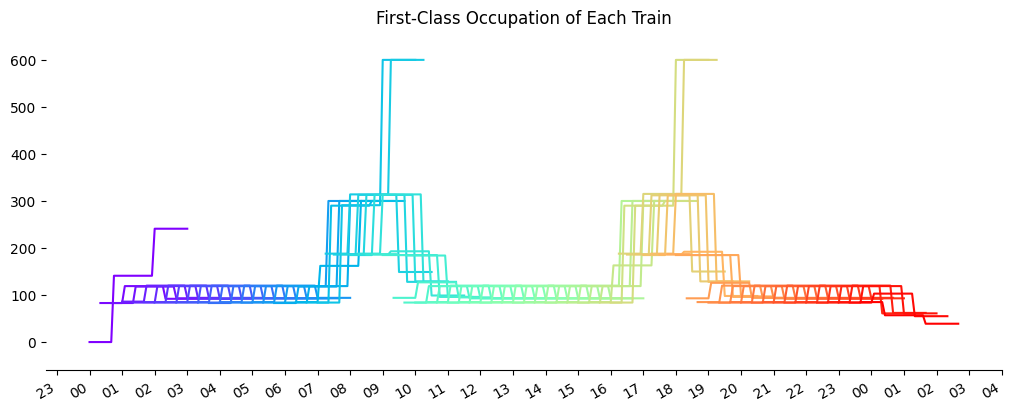

In [19]:
def plot_first_carriages_occupation(all_trains, all_passengers):
    all_trains = sorted(all_trains, key=lambda x: x.depart_time)
    # plot the first class  occupation of the trains on the three parts of the journey during the day
    fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")
    ax.set(title="First-Class Occupation of Each Train")

    color = iter(cm.rainbow(np.linspace(0, 1, len(all_trains))))
    for train in all_trains:
        dates = [train.departure_times[0], train.arrival_times[1],
                 train.departure_times[1], train.arrival_times[2],
                 train.departure_times[2], train.arrival_times[3]]
        ax.plot(dates, [train.first_class_occupation[0], train.first_class_occupation[0],
                        train.first_class_occupation[1], train.first_class_occupation[1],
                        train.first_class_occupation[2], train.first_class_occupation[2]], "-",
                color=next(color), markerfacecolor="w")  # Baseline and markers on it.

    # format x-axis with 4-month intervals
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y-axis and spines
    ax.spines[["left", "top", "right"]].set_visible(False)

    ax.margins(y=0.1)
    plt.show()
    
plot_first_carriages_occupation(all_trains, all_passengers)

## Second-Class Occupation of Each Train
Each train is represented by a color. The x-axis represents the time of the day and the y-axis represents the occupation of the second class carriages.

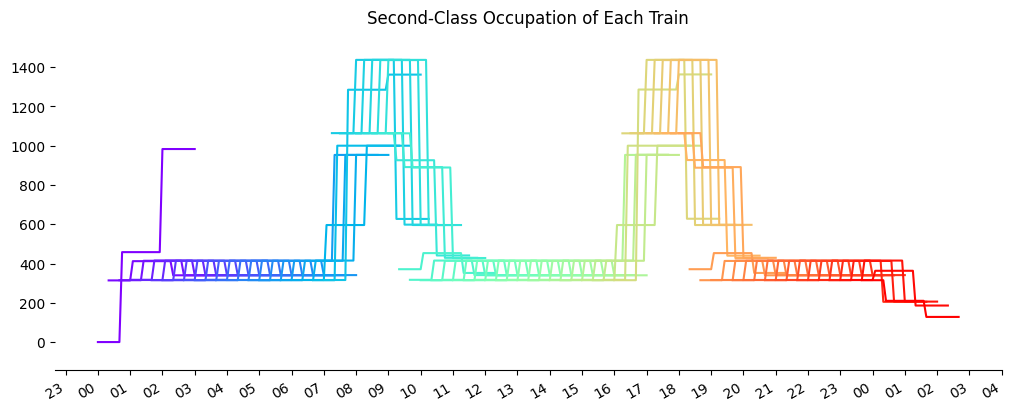

In [20]:
def plot_second_carriages_occupation(all_trains, all_passengers):
    all_trains = sorted(all_trains, key=lambda x: x.depart_time)
    # plot the first class  occupation of the trains on the three parts of the journey during the day
    fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")
    ax.set(title="Second-Class Occupation of Each Train")

    color = iter(cm.rainbow(np.linspace(0, 1, len(all_trains))))
    for train in all_trains:
        dates = [train.departure_times[0], train.arrival_times[1],
                 train.departure_times[1], train.arrival_times[2],
                 train.departure_times[2], train.arrival_times[3]]
        ax.plot(dates, [train.second_class_occupation[0], train.second_class_occupation[0],
                        train.second_class_occupation[1], train.second_class_occupation[1],
                        train.second_class_occupation[2], train.second_class_occupation[2]], "-",
                color=next(color), markerfacecolor="w")  # Baseline and markers on it.

    # format x-axis with 4-month intervals
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y-axis and spines
    ax.spines[["left", "top", "right"]].set_visible(False)

    ax.margins(y=0.1)
    plt.show()
    
plot_second_carriages_occupation(all_trains, all_passengers)

## Number of First-Class Carriages depending on the Departure Time
Each point represents a train, the x-axis represents the departure time and the y-axis represents the number of first class carriages.

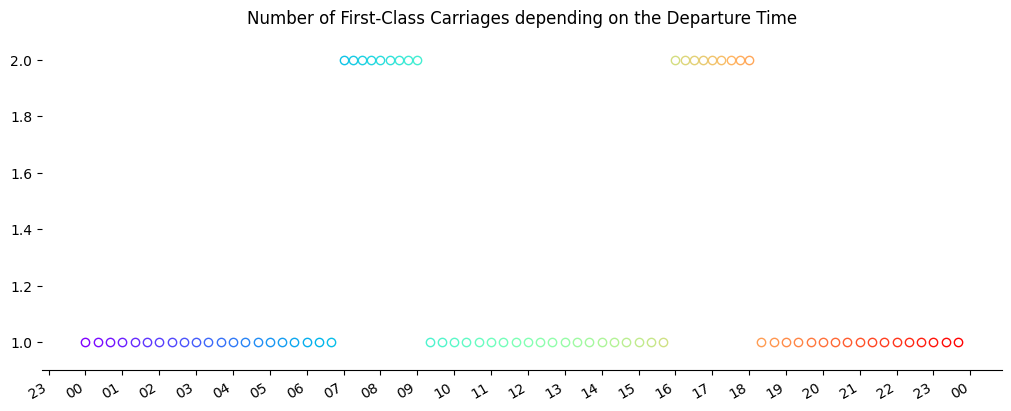

In [21]:
def plot_first_carriages_number(all_trains, all_passengers):
    all_trains = sorted(all_trains, key=lambda x: x.depart_time)
    # plot the number of carriages of the trains during the day 
    fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")
    ax.set(title="Number of First-Class Carriages depending on the Departure Time")

    color = iter(cm.rainbow(np.linspace(0, 1, len(all_trains))))
    for train in all_trains:
        dates = [train.departure_times[0]]
        ax.plot(dates, [train.nb_first_class_carriage], "o",
                color=next(color), markerfacecolor="w")  # Baseline and markers on it.

    # format x-axis with 4-month intervals
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y-axis and spines
    ax.spines[["left", "top", "right"]].set_visible(False)

    ax.margins(y=0.1)
    plt.show()

    
plot_first_carriages_number(all_trains, all_passengers)

## Number of Second-Class Carriages depending on the Departure Time
Each point represents a train, the x-axis represents the departure time and the y-axis represents the number of second class carriages.

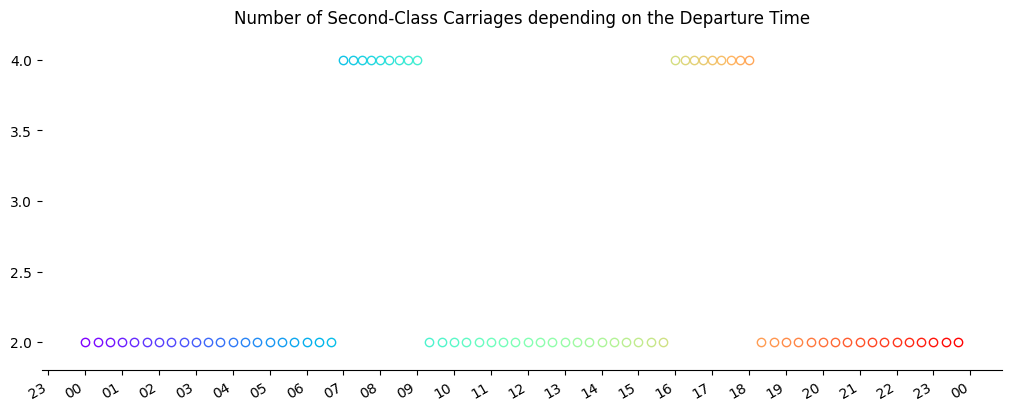

In [22]:
def plot_second_carriages_number(all_trains, all_passengers):
    all_trains = sorted(all_trains, key=lambda x: x.depart_time)
    # plot the number of carriages of the trains during the day 
    fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")
    ax.set(title="Number of Second-Class Carriages depending on the Departure Time")

    color = iter(cm.rainbow(np.linspace(0, 1, len(all_trains))))
    for train in all_trains:
        dates = [train.departure_times[0]]
        ax.plot(dates, [train.nb_second_class_carriage], "o",
                color=next(color), markerfacecolor="w")  # Baseline and markers on it.

    # format x-axis with 4-month intervals
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y-axis and spines
    ax.spines[["left", "top", "right"]].set_visible(False)

    ax.margins(y=0.1)
    plt.show()
    
plot_second_carriages_number(all_trains, all_passengers)

## Time between Consecutive Trains at Each Station 
Boxplots of the time between 2 consecutive trains at each station during peak and off-peak hours.

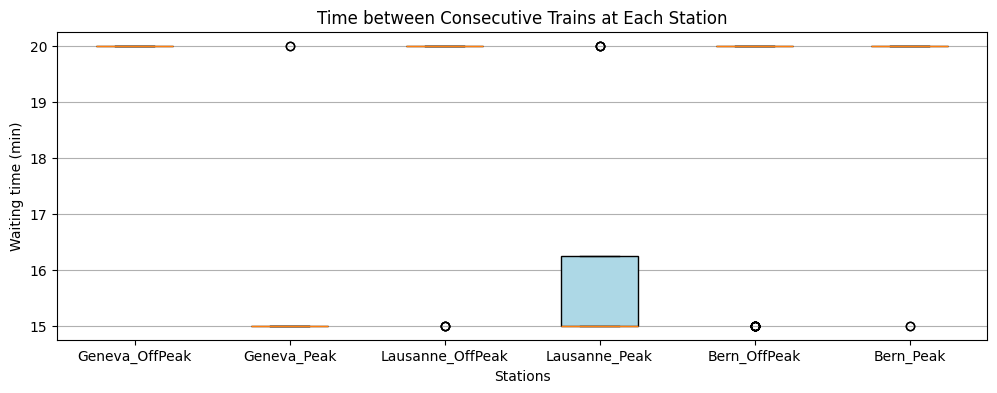

In [23]:
def plot_consecutive_train_time(all_trains, all_passengers):
    all_trains = sorted(all_trains, key=lambda x: x.depart_time)
    # waiting time of the trains (time between 2 trains) at each station during peak and off-peak periods 
    waiting_time_list = []
    for station_id, station in enumerate(STATIONS[:-1]):
        waiting_time_off_peak = []
        waiting_time_peak = []
        for train_id, train in enumerate(all_trains[:-1]):
            if peak_hour(train.departure_times[station_id]):
                waiting_time_peak.append((all_trains[train_id+1].departure_times[station_id] - train.departure_times[station_id]).total_seconds()/60)
            else:
                waiting_time_off_peak.append((all_trains[train_id+1].departure_times[station_id] - train.departure_times[station_id]).total_seconds()/60)        
        waiting_time_list.append(waiting_time_off_peak)
        waiting_time_list.append(waiting_time_peak)

    fig, ax = plt.subplots(figsize=(12, 4))

    # rectangular box plot
    labels = ['Geneva_OffPeak', 'Geneva_Peak', 'Lausanne_OffPeak', 'Lausanne_Peak', 'Bern_OffPeak', 'Bern_Peak']
    bplot = ax.boxplot(waiting_time_list,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
    ax.set_title('Time between Consecutive Trains at Each Station')


    # fill with colors
    colors = ['pink', 'lightblue', 'pink', 'lightblue', 'pink', 'lightblue']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # adding horizontal grid lines
    ax.yaxis.grid(True)
    ax.set_xlabel('Stations')
    ax.set_ylabel('Waiting time (min)')

    plt.show()


plot_consecutive_train_time(all_trains, all_passengers)

## Passengers' Waiting Times 
Histogram of all the passengers waiting times at their origin station.

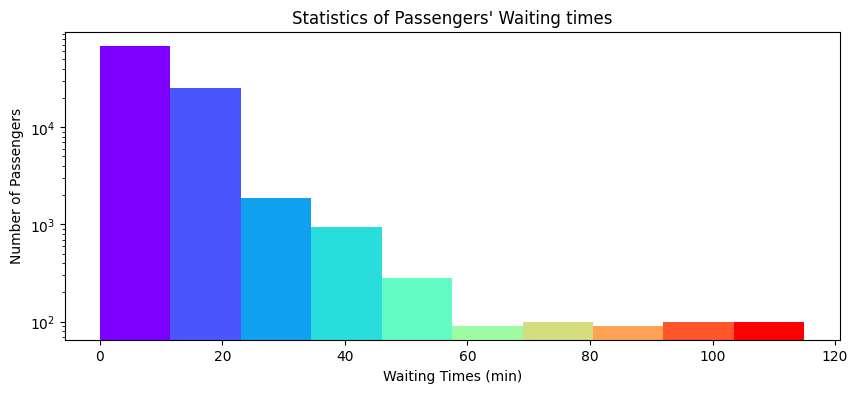

In [24]:
def plot_passenger_waiting_time(all_trains, all_passengers):
    # histogram of the waiting times of the passengers 
    waiting_time_passengers = [passenger.waiting_time.total_seconds()/60 for passenger in all_passengers]
    # print(np.mean(waiting_time_passengers), np.std(waiting_time_passengers))

    plt.figure(figsize=(10, 4))
    n, bins, patches = plt.hist(waiting_time_passengers)

    color = iter(cm.rainbow(np.linspace(0, 1, len(n))))
    for c, p in zip(n, patches):
        plt.setp(p, 'facecolor', next(color))

    plt.title("Statistics of Passengers' Waiting times")
    plt.ylabel("Number of Passengers")
    plt.xlabel("Waiting Times (min)")
    plt.yscale("log", base=10)
    plt.show()
    
plot_passenger_waiting_time(all_trains, all_passengers)

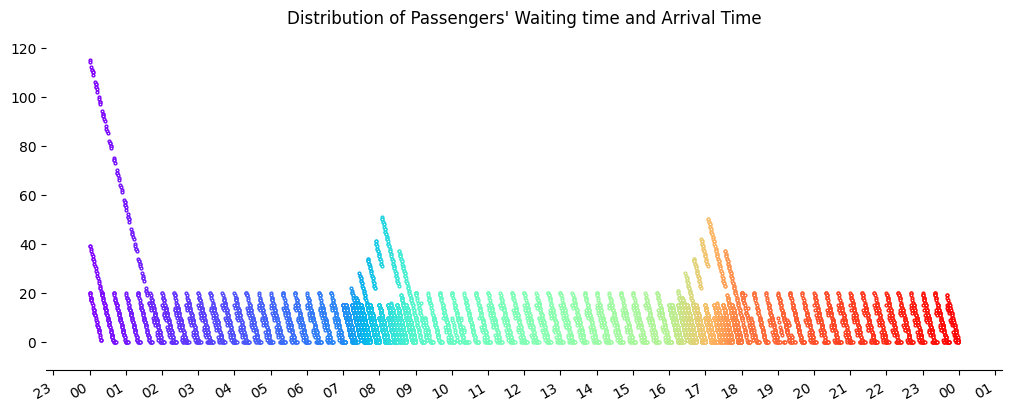

In [25]:
def plot_passenger_waiting_time_per_arrival(all_trains, all_passengers):
    fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")
    ax.set(title="Distribution of Passengers' Waiting time and Arrival Time")


    color = iter(cm.rainbow(np.linspace(0, 1, len(all_passengers[::10]))))
    for passenger in all_passengers[::10]:
        dates = [passenger.arrival_time]
        ax.plot(dates, [passenger.waiting_time.total_seconds()/60], "o",
                color=next(color), markerfacecolor="w", markersize=2)  # Baseline and markers on it.

    # format x-axis with 4-month intervals
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y-axis and spines
    ax.spines[["left", "top", "right"]].set_visible(False)

    ax.margins(y=0.1)
    plt.show()

plot_passenger_waiting_time_per_arrival(all_trains, all_passengers) 

## Waiting Time of Passengers at Each Station 
Boxplots of the waiting times of the passengers at each station.

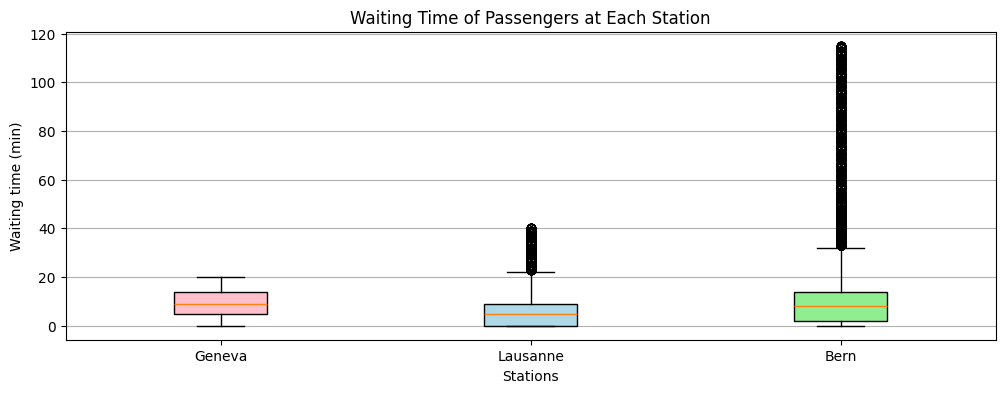

In [26]:
def plot_passenger_waiting_time_per_station(all_trains, all_passengers):
    # plot the passengers' waiting time at each station during the day
    waiting_time_list = []
    for station in STATIONS[:-1]:
        waiting_time_per_station = []
        for passenger in all_passengers:
            if passenger.origin == station: 
                waiting_time_per_station.append(passenger.waiting_time.total_seconds()/60)
        waiting_time_list.append(waiting_time_per_station)

    fig, ax = plt.subplots(figsize=(12, 4))

    # rectangular box plot
    labels = ['Geneva', 'Lausanne', 'Bern']
    bplot = ax.boxplot(waiting_time_list,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
    ax.set_title('Waiting Time of Passengers at Each Station')


    # fill with colors
    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # adding horizontal grid lines
    ax.yaxis.grid(True)
    ax.set_xlabel('Stations')
    ax.set_ylabel('Waiting time (min)')

    plt.show()

plot_passenger_waiting_time_per_station(all_trains, all_passengers)

# Step 6: Statistical Analysis

### Example of One Simulation Run

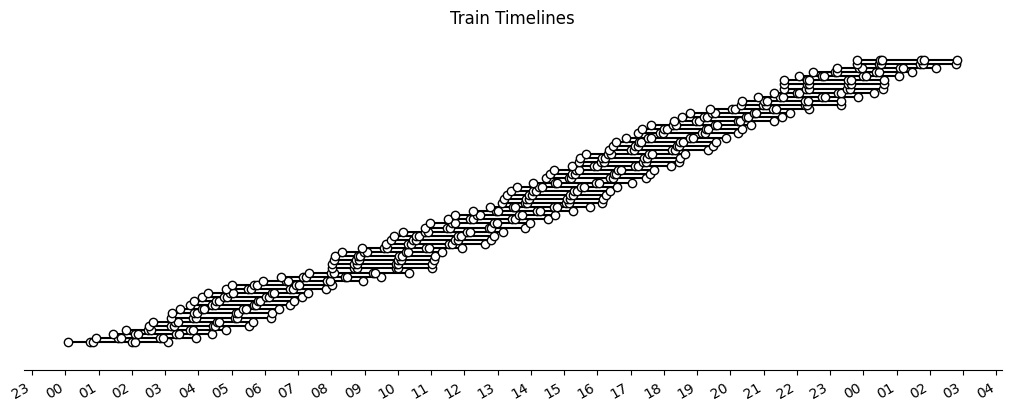

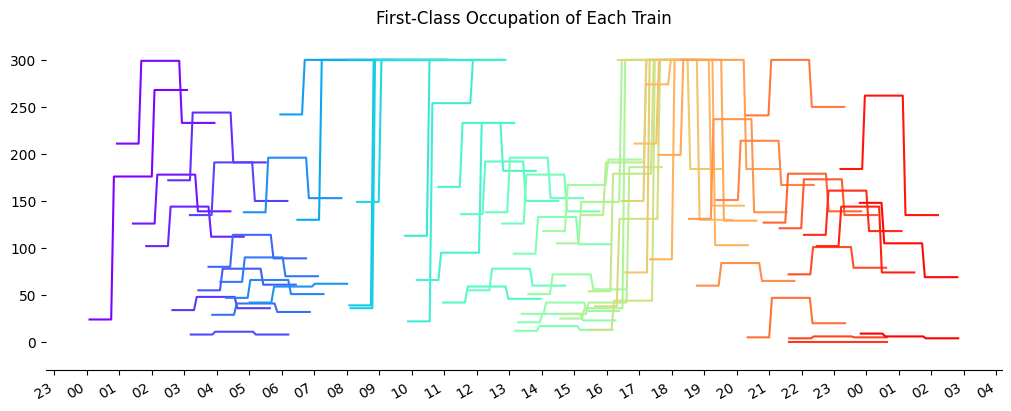

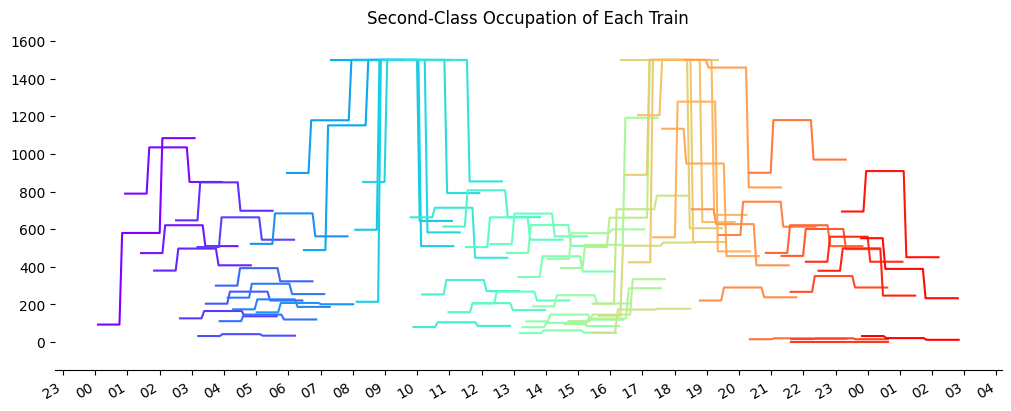

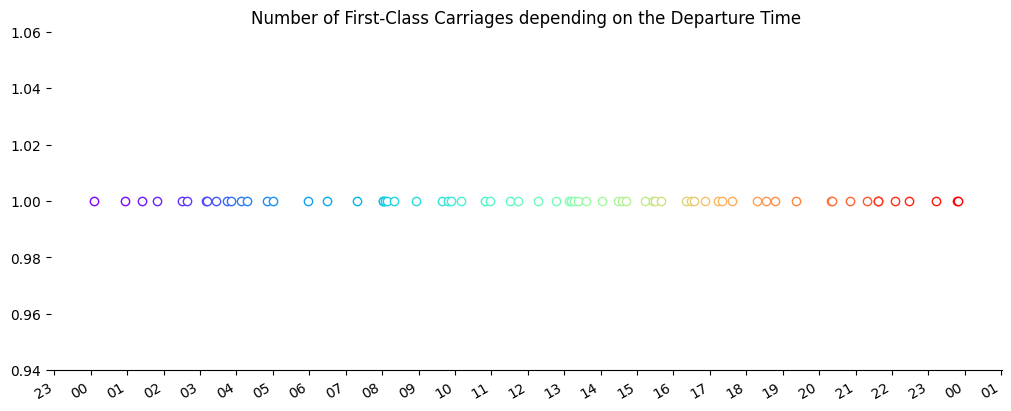

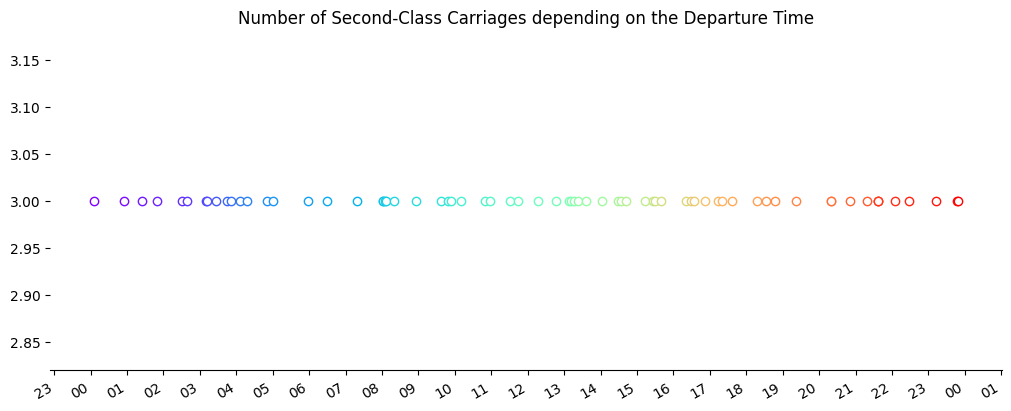

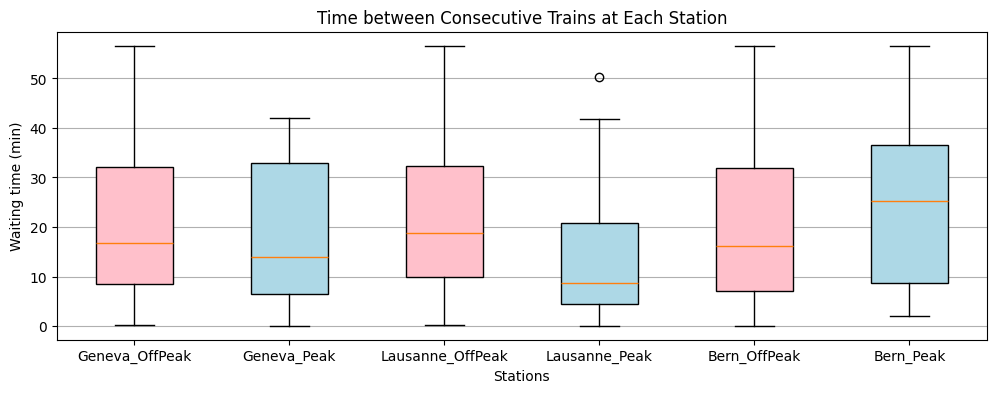

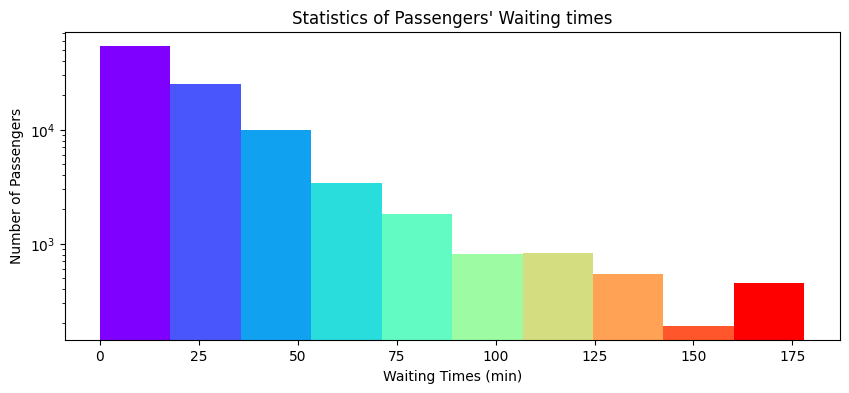

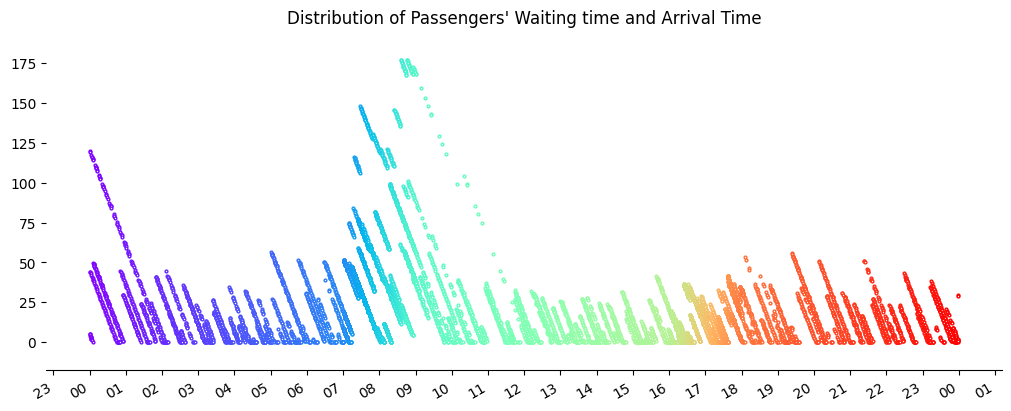

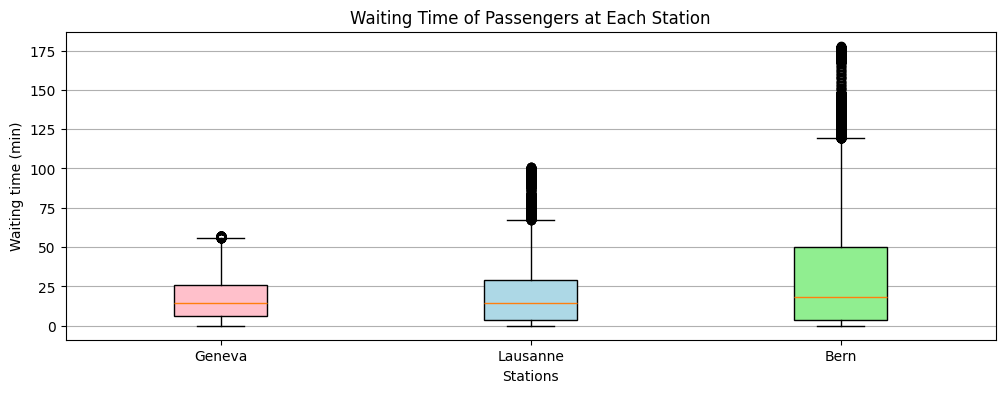

In [27]:
all_trains, all_passengers = Scenario(5, False)

# Visualize all results
## Train Properties
plot_train_timelines(all_trains, all_passengers)
plot_first_carriages_occupation(all_trains, all_passengers)
plot_second_carriages_occupation(all_trains, all_passengers)
plot_first_carriages_number(all_trains, all_passengers)
plot_second_carriages_number(all_trains, all_passengers)
plot_consecutive_train_time(all_trains, all_passengers)
## Passenger Properties
plot_passenger_waiting_time(all_trains, all_passengers)
plot_passenger_waiting_time_per_arrival(all_trains, all_passengers) 
plot_passenger_waiting_time_per_station(all_trains, all_passengers)

### Estimation of the Passenger's Waiting Time
#### Mean/Variance/Maximum of Passengers' Waiting Time 

In [28]:
def get_mean_waiting_time(all_passengers):
    # get mean of the passenger waiting times for one simulation 
    return np.mean([passenger.waiting_time.total_seconds() / 60 for passenger in all_passengers])

def get_std_waiting_time(all_passengers):
    # get std of the passenger waiting times for one simulation 
    return np.std([passenger.waiting_time.total_seconds() / 60 for passenger in all_passengers])

def get_max_waiting_time(all_passengers):
    # get maximum of the passenger waiting times for one simulation
    return np.max([passenger.waiting_time.total_seconds() / 60 for passenger in all_passengers])

In [29]:
def moving_mean_var(new_data, old_mean, old_var, t):
    """ Calculates moving sample mean and variance at time t.
    
    Keywords:
        new_data (float): new data point arriving at time t.
        old_mean (float): previous sample mean.
        old_var (float) : previous sample variance.
        t (int): time index
    
    Returns:
        new_mean (float): updated sample mean.
        new_var (float): updated sample variance.
    """
    new_mean = old_mean + (new_data - old_mean)/t
    new_var  = (1-1/(t-1)) * old_var + (t) * (new_mean - old_mean)**2 
    return new_mean, new_var 

In [30]:
criterion_stop = 0.5

mean_mean_list = []  # mean of the mean waiting time of each simulation
mean_std_list  = []  # mean of the std waiting time of each simulation
mean_max_list  = []  # mean of the max waiting time of each simulation
std_mean_list  = []  # std of the mean waiting time of each simulation
std_std_list   = []  # std of the std waiting time of each simulation
std_max_list   = []  # std of the max waiting time of each simulation
time_steps     = []

# Initialization
t = 1
SIM_FLAG = True
all_trains, all_passengers = Scenario(4, True)

# get the mean, std and maximum of the waiting time for all passengers
new_mean_wt = get_mean_waiting_time(all_passengers)
new_std_wt  = get_std_waiting_time(all_passengers)
new_max_wt  = get_max_waiting_time(all_passengers)
mean_list = [new_mean_wt] # mean waiting time of each run
std_list  = [new_std_wt]  # std dev waiting time of each run
max_list  = [new_max_wt]  # maximum of waiting time of each run
mean_mean, var_mean = new_mean_wt , 0
mean_std, var_std   = new_std_wt  , 0
mean_max, var_max   = new_max_wt  , 0

# loop
while SIM_FLAG:
    # Decision Criterion
    if t > 100 and np.sqrt(var_mean/t) < criterion_stop:
        SIM_FLAG = False
        
    # simulate a new run
    t += 1

    all_trains, all_passengers = Scenario(4, True)

    # get the mean and std of the waiting time of the passengers
    new_mean_wt = get_mean_waiting_time(all_passengers)
    new_std_wt  = get_std_waiting_time(all_passengers)
    new_max_wt  = get_max_waiting_time(all_passengers)

    mean_list.append(new_mean_wt)
    std_list.append(new_std_wt)
    max_list.append(new_max_wt)

    # update the mean and std of the mean and std of the waiting time of the passengers
    mean_mean, var_mean = moving_mean_var(new_mean_wt, mean_mean, var_mean, t)
    mean_std,  var_std  = moving_mean_var(new_std_wt, mean_std, var_std, t)
    mean_max,  var_max  = moving_mean_var(new_max_wt, mean_max, var_max, t)

    mean_mean_list.append(mean_mean)
    mean_std_list.append(mean_std)
    mean_max_list.append(mean_max)

    std_mean_list.append(np.sqrt(var_mean))
    std_std_list.append(np.sqrt(var_std))
    std_max_list.append(np.sqrt(var_max))
    time_steps.append(t)

    print(f'========== RUN No.{t} ==========')
    print(f"Mean of Waiting Time: {new_mean_wt}")
    print(f"Variance of Waiting Time: {new_std_wt}")
    print(f"Maximum of Waiting Time: {new_max_wt}")
    print(f"Criterion: {np.sqrt(var_mean/t)}")


========== RUN No.2 ==========
Mean of Waiting Time: 8.884818141958377
Variance of Waiting Time: 9.37564790077326
Maximum of Waiting Time: 115.0
Criterion: 0.0009348685010746038
========== RUN No.3 ==========
Mean of Waiting Time: 8.888967482675195
Variance of Waiting Time: 9.172502908117636
Maximum of Waiting Time: 115.0
Criterion: 0.001778611215846395
========== RUN No.4 ==========
Mean of Waiting Time: 8.873311989492263
Variance of Waiting Time: 9.286338044172126
Maximum of Waiting Time: 115.0
Criterion: 0.00331439020220036
========== RUN No.5 ==========
Mean of Waiting Time: 8.78753587368378
Variance of Waiting Time: 9.162559672806864
Maximum of Waiting Time: 115.0
Criterion: 0.01916783580533928
========== RUN No.6 ==========
Mean of Waiting Time: 8.80441921129354
Variance of Waiting Time: 9.185619703572542
Maximum of Waiting Time: 115.0
Criterion: 0.018491903247068942
========== RUN No.7 ==========
Mean of Waiting Time: 8.819964916240087
Variance of Waiting Time: 9.30419104668023




 Total Number of Simulations :  101


Text(0.5, 1.0, 'Recursive STDEV of the Mean Waiting Time and stdev Waiting Time along Simulations')

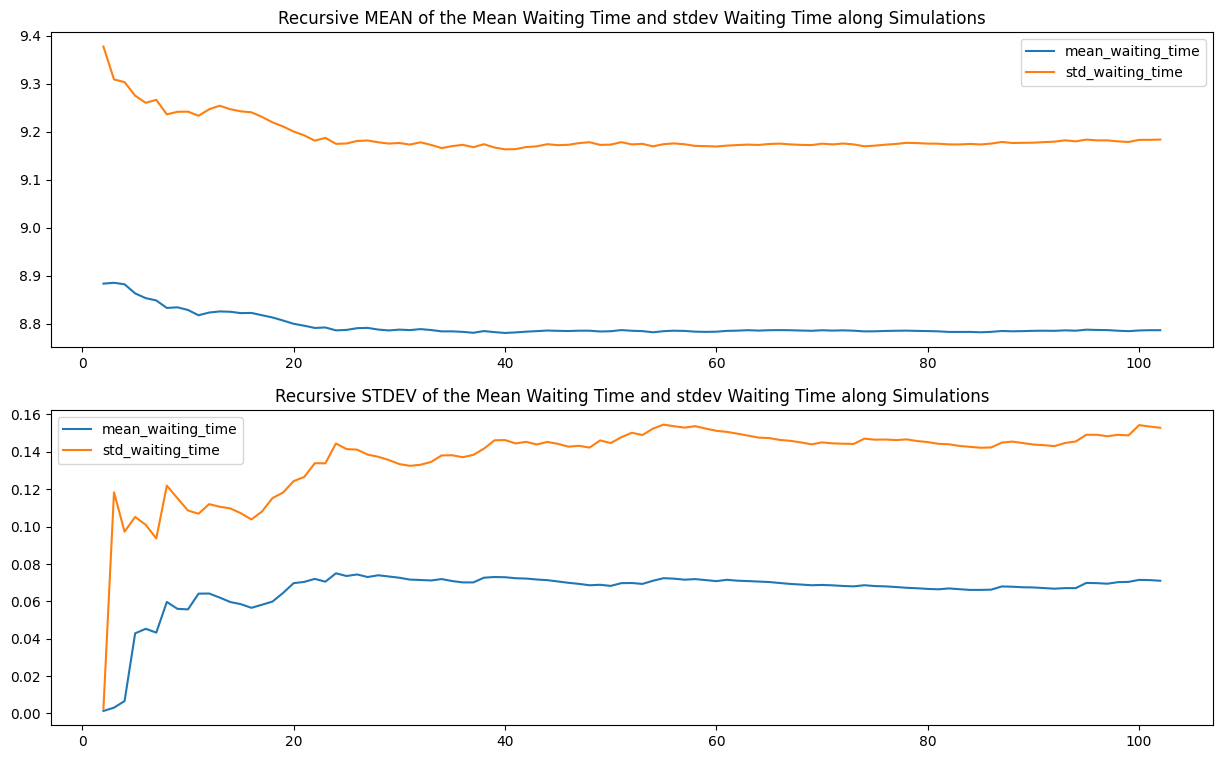

In [31]:
print("\n\n Total Number of Simulations : ",len(time_steps))

plt.subplots(2, 1, figsize=(15, 9))
plt.subplot(2,1,1)
plt.plot(time_steps, mean_mean_list, label='mean_waiting_time')
plt.plot(time_steps, mean_std_list, label='std_waiting_time')
plt.legend()
plt.title("Recursive MEAN of the Mean Waiting Time and stdev Waiting Time along Simulations")

plt.subplot(2,1,2)
plt.plot(time_steps, std_mean_list,  label='mean_waiting_time')
plt.plot(time_steps, std_std_list,  label='std_waiting_time')
plt.legend()
plt.title("Recursive STDEV of the Mean Waiting Time and stdev Waiting Time along Simulations")

### MSE Estimation with Bootstrapping
For Mean and STD of Waiting Time for All Simulation Runs

In [32]:
def bootstrap(data, f_statistic, draws):
    """ Calculates the bootstrap mse of a statistic of choice
    
    Keywords:
        data (array): data array.
        f_statistic: function handle calculating the statistic of interest.
        draws (int): number of bootstrap draws.
    
    Returns:
        mse (float): mean square error of the statistic of interest.
    """
    data.sort()
    theta = float(f_statistic(data))
    print(f'theta = {theta:.4f}')
    sum = 0.0
    for l in range(0, draws):
        n = len(data)
        b = []
        for i in range(0, n):
            r = np.random.uniform(0,1)
            index = int(n * r)
            b.append(data[index])
        b.sort()
        theta_hat = float(f_statistic(b))
        sum += (theta - theta_hat) ** 2
    print(f'MSE: {sum/draws:.4f} sqrt(MSE): {np.sqrt(sum/(draws)):.4f}')

In [33]:
data = mean_list # or std_waiting_time/max_waiting_time
bootstrap(data, np.mean, 1000)
bootstrap(data, np.std, 1000)
bootstrap(data, np.max, 1000)

theta = 8.7869
MSE: 0.0000 sqrt(MSE): 0.0070
theta = 0.0707
MSE: 0.0000 sqrt(MSE): 0.0045
theta = 8.9880
MSE: 0.0012 sqrt(MSE): 0.0347


## Variance reduction 

#### Independant runs


In [34]:
precision = 3
var_mean_wt = 0
mean_wt_all = []
mean_mean_wt_all = []
var_mean_wt_all = []
run = 1

all_trains, all_passengers = Scenario(5, True)
mean_mean_wt = np.mean([passenger.waiting_time.total_seconds()/60 for passenger in all_passengers])
#Main loop
while True:
    run += 1
    print(np.sqrt(var_mean_wt / run))
    
    #Run simulation
    u = np.random.rand(2, 200)
    all_trains, all_passengers = Scenario(5, True)
    
    mean_waiting_time = np.mean([passenger.waiting_time.total_seconds()/60 for passenger in all_passengers])
    
    #Collect statistics
    mean_mean_wt, var_mean_wt = moving_mean_var(mean_waiting_time, mean_mean_wt, var_mean_wt, run)
    mean_wt_all.append(mean_waiting_time)
    mean_mean_wt_all.append(mean_mean_wt)
    var_mean_wt_all.append(var_mean_wt)
    
    #Check if necessary precision reached
    if run >= 100 and np.sqrt(var_mean_wt / run) < precision:
        break

sd_independent = np.sqrt(var_mean_wt_all)

0.0
3.879233477444197
3.0727968051628105
2.250802018395323
1.9248178995988592
1.8063859196356633
1.555239088863621
1.5729799093651073
1.5985305336485651
1.4704337769980518
1.4130528844707448
1.430940857283193
1.3796089415333914
1.312761774000345
1.2475505868952708
1.234978482418099
1.1905289767002878
1.1261333028476121
1.0668342096988253
1.0509769733235321
1.0304207731469077
0.9881413770575015
0.9680094315144013
0.9317398306055574
0.9011095597420407
1.0698783917269676
1.0335745063558823
0.9973092994612589
0.9920411208169031
1.0658235446482605
1.0314093088451883
1.0031230217413523
0.9727462395214362
0.9701817559910001
0.9427528203424822
0.9167224228394532
1.0291298111377092
1.0324220515406193
1.0089047479245943
0.9976072177069175
0.9756667715732407
0.9680884584511676
0.9578112122065563
0.9399250026769745
0.9239074538660014
0.9046033617336813
0.8858013288151181
0.8846298067639593
0.8713666023497524
0.8585425164975622
0.9194110229557724
0.916941221918327
0.9055255454688695
0.9093456409114

#### Antithetic runs

In [35]:
precision = 3
var_mean_wt = 0
mean_wt_all = []
mean_mean_wt_all = []
var_mean_wt_all = []
run = 1

all_trains, all_passengers = Scenario(5, True)
mean_mean_wt = np.mean([passenger.waiting_time.total_seconds()/60 for passenger in all_passengers])

#Main loop
while True:
    run += 1
    print(np.sqrt(var_mean_wt / run))
    #Run simulation
    u = np.random.rand(2, 100)
    u = np.concatenate((u, 1-u), axis = 1)
    all_trains, all_passengers = Scenario(5, True)
    mean_waiting_time = np.mean([passenger.waiting_time.total_seconds()/60 for passenger in all_passengers])
    
    #Collect statistics
    mean_mean_wt, var_mean_wt = moving_mean_var(mean_waiting_time, mean_mean_wt, var_mean_wt, run)
    mean_wt_all.append(mean_waiting_time)
    mean_mean_wt_all.append(mean_mean_wt)
    var_mean_wt_all.append(var_mean_wt)
    
    #Check if necessary precision reached
    if run >= 100 and np.sqrt(var_mean_wt / run) < precision:
        break

sd_antithetic = np.sqrt(var_mean_wt_all)

0.0
3.2172130662028247
2.046721800606449
1.9462899001651979
1.7431075530656261
1.8283067787480443
1.6465848277846007
1.4386672771256637
1.2938249661669425
1.1899366532489655
1.2521280461312316
1.1924720611405015
1.1582278403670747
1.1880630668781984
1.1163748385819334
1.0699817295139127
1.1085279530132655
1.0472319067394933
1.0701487089010386
1.049768402594382
0.9999301889645646
1.068534169754998
1.0378848603306374
1.098482998122214
1.0606458825407867
1.034736079582222
1.008454227896321
0.9726520726261411
0.9393378326794933
0.911630881445937
0.8980126725122157
0.8710525027310938
0.8504265852288734
0.8358668940532061
0.8142557845500712
0.8116497387323027
0.7966784868126782
0.8135837069659779
0.7929665343458632
0.7737249698215085
0.7573733199519519
0.7395237942201518
0.7266201642224276
0.7131092473294306
0.6995458536929098
0.6843455161274363
0.6726098933350831
0.6621895353213059
0.6486796127811197
0.6371314731196162
0.6385042743105749
0.6365818799413715
0.6294250071063495
0.6179648336893

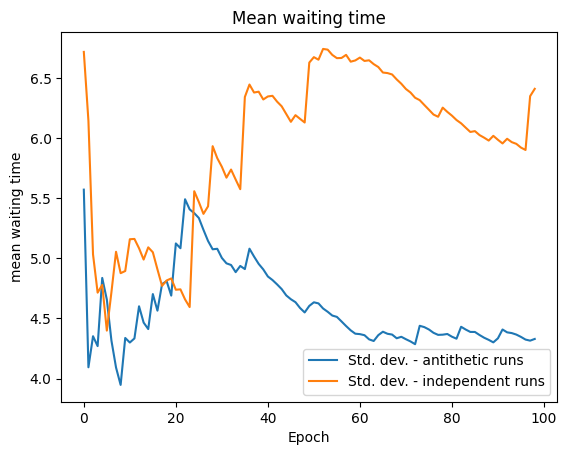

In [36]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(sd_antithetic, label='Std. dev. - antithetic runs')
ax.plot(sd_independent, label='Std. dev. - independent runs')
ax.set(title='Mean waiting time',
       xlabel='Epoch',
       ylabel='mean waiting time')
ax.legend()
plt.show()

# Section 2: Optimiztion

## Single-Objective Optimization

To integrate the optimization model with the simulation effectively, we first define the decision variables, the objective function, and constraints, and then use simulation to evaluate these decisions. Here are the steps for problem modeling:

### 1. Decision Variables

Based on the previous simulation code, we can define two types of decision variables:

- **Departure times** $ T_i $: The specific departure times for each train.
- **Carriage configurations** $ C_{i,j} $: The number of carriages of type $ j $ for train $ i $, where $ j $ could be either first or second class (0 or 1)
- **Number of trains** $ N $: The total number of trains to be scheduled.



In [37]:
train_configurations = 3
max_departure_hour = 24  # 一天中的小时数
# The number of hours in a day
# Le nombre d'heures dans une journée
ALL_CARRIAGE_CONFIG = [(1, 2), (2, 4), (1, 3), (1, 4), (2, 3)] # all possible train configurations

def define_timeline(carriage_configurations, departure_times, number_trains):
    """Define all the trains and passengers with the decision variables"""
    trains_schedule = [Train(departure_times[i], carriage_configurations[i][0], carriage_configurations[i][1], [timedelta(minutes=5), timedelta(minutes=5)]) for i in range(number_trains)] # list of all trains
    all_passengers = constant_passenger_arrivals() # list of all passengers
    trains_passengers_management(all_passengers, trains_schedule)
    return trains_schedule, all_passengers

# 初始化决策变量
# Initialize decision variables
# Initialiser les variables de décision
objective_function_choice = "cost"  # "waiting_time" or "cost"
initial_number_trains = 40 
initial_carriage_configurations = random.choices(ALL_CARRIAGE_CONFIG[0:3], k=initial_number_trains) # configurations of the trains (number of carriages in first and second class)
initial_departure_times = [datetime(2000, 1, 1, hour=i) for i in range(24) ]
initial_departure_times += [datetime(2000, 1, 1, hour=0) + timedelta(hours=i) for i in sorted(np.random.uniform(0,24,initial_number_trains-24))] # departure times of the trains

initial_trains_schedule, all_passengers = define_timeline(initial_carriage_configurations, initial_departure_times, initial_number_trains)

### 2. Objective Function

The objective function should reflect the goal of improving service quality and operational efficiency. We could consider the following aspects:

- **Minimize total passenger waiting time**:
  $$
  \text{Minimize } Z = \sum_{p \in P} w_p
  $$
  where $ w_p $ is the waiting time for passenger $ p $, and $ P $ is the set of all passengers.

- **Minimize company cost**:
  $$
  \text{Minimize } C = \sum_{t \in T} c_\text{empty\_seat} + \sum_{t \in T} c_\text{missed\_compensate} - \sum_{p \in P} c_\text{ticket}
  $$
  where $ c $ is the cost paid by the company for missed trains by passengers and empty seats, substracted by incomes from passengers' ticket, and $ T $ is the set of all trains.

In [38]:
def evaluate_waiting_time(all_passengers):
    # evaluate total waiting time of all passengers 
    total_waiting_time = np.sum([passenger.waiting_time.total_seconds()/60 for passenger in all_passengers])
    return total_waiting_time

def evaluate_cost(trains_schedule, all_passengers):
    # evaluate total cost by the company = cost of empty seats + cost of missed trains
    cost_empty_seats = np.sum([train.define_cost_empty_seats() for train in trains_schedule])
    cost_missed_trains = 0
    income_tickets = 0
    for passenger in all_passengers:
        if passenger.train_missed_full > 0:
            if passenger.first_second_class:
                cost_missed_trains += passenger.train_missed_full * COST_MISSING_FIRST_CLASS
            else:
                cost_missed_trains += passenger.train_missed_full * COST_MISSING_SECOND_CLASS
        income_tickets += passenger.ticket_price
    return cost_empty_seats + cost_missed_trains - income_tickets

def objective_function(trains_schedule, all_passengers, objective_function):
    # objective function: 'waiting_time' or 'cost' 
    if objective_function == 'waiting_time':
        objective = evaluate_waiting_time(all_passengers)
    elif objective_function == 'cost':
        objective = evaluate_cost(trains_schedule, all_passengers)
    return objective 


### 3. Constraint

- **Limit on different train configurations**: No more than 3 different configurations of trains per day.
  $$
  |\{C_{i,j}\}| \leq 3
  $$

- **Limit on the departure times**: The departure times should be within the operating hours.
  $$
  T_i \in [T_{\text{start}}, T_{\text{end}}]
  $$

- **Interval between two trains**: The interval between two trains should be less than 1 hour.


In [39]:
def check_constraints(carriage_configurations, departure_times, number_trains):
    configurations = set(carriage_configurations)
    Tstart = datetime(2000, 1, 1, hour=0)
    Tend = datetime(2000, 1, 2, hour=0)
    
    constraint_interval_trains = True
    departure_times_ = sorted(departure_times)
    for i in range(number_trains-1):
        interval = departure_times_[i+1] - departure_times_[i] 
        if interval > timedelta(hours=1) or interval == timedelta(minutes=0):
            constraint_interval_trains = False
            break
            
    return len(configurations) <= 3 and all([Tstart <= t <= Tend for t in departure_times]) and constraint_interval_trains 

### 4. Optimization Algorithm
We decide to study the following optimization algorithms:
- Variable Neighborhood Search (VNS)
- Simulated Annealing (SA)

#### VNS

In [40]:
def neighborhood_trains(carriage_configurations, departure_times, trains_schedule):
    """We define in this function the neighborhood of our solutions. 
       The neighborhood is defined by n neighbors
       A neighbor can be defined by: 
        - adding or removing a train
        - changing the configuration of one or more train(s)
        - changing the departure time of one or more train(s)"""
    neighborhood = []
    nb_neighbors = 50
    sol_carriage_configurations = deepcopy(carriage_configurations)
    # print("sol carriage configurations", sol_carriage_configurations)
    sol_departure_times = deepcopy(departure_times)
    sol_trains_schedule = deepcopy(trains_schedule)
    number_trains = len(sol_trains_schedule)
    CURRENT_CARRIAGE_CONFIG = list(set(carriage_configurations))
    for _ in range(nb_neighbors):
        respect_constraints = False
        while not respect_constraints:
            # start from initial schedule
            carriage_configurations = deepcopy(sol_carriage_configurations)
            departure_times = deepcopy(sol_departure_times)
            trains_schedule = deepcopy(sol_trains_schedule)
            number_trains = len(trains_schedule)
            # we add or remove one train to the schedule with probability 0.5

            if np.random.uniform(0, 1) > 0.5:
                hazard = np.random.choice([-1, 1], 1)
                if hazard == 1:
                    # add randomly one train
                    number_trains += 1
                    departure_times.append(datetime(2000, 1, 1, hour=0) + timedelta(hours=np.random.uniform(0,24)))
                    carriage_configurations.append(random.sample(CURRENT_CARRIAGE_CONFIG, 1)[0])
                else: 
                    # remove randomly one train 
                    number_trains -= 1
                    idx = np.random.choice(range(len(trains_schedule)), 1)[0]
                    del trains_schedule[idx]
                    del departure_times[idx]
                    del carriage_configurations[idx]
                    
#             # we change the configuration of one or more trains with probability +/nb_trains for each train 
#             for i in range(number_trains):
#                 if np.random.uniform(0, 1) < 1/number_trains:
#                     carriage_configurations[i] = random.sample(ALL_CARRIAGE_CONFIG, 1)[0]
            
            # we change the departure time of one or more trains with probability +/nb_trains for each train (+ or - 10mins)
#             for i in range(number_trains):
#                 if np.random.uniform(0, 1) < 0.5:
#                     departure_times[i] = departure_times[i] + timedelta(minutes=int(np.random.choice([-10, 10], 1)[0]))
            
            # check if the constraints are respected
            
            respect_constraints = check_constraints(carriage_configurations, departure_times, number_trains)
        neighborhood.append((carriage_configurations, departure_times, number_trains))
            
    return neighborhood

In [41]:
def variable_neighborhood_search(carriage_configurations, departure_times, trains_schedule, all_passengers, max_iterations=1000, display=False):
    best_solution = (deepcopy(carriage_configurations), deepcopy(departure_times), deepcopy(trains_schedule))
    best_score = objective_function(trains_schedule, all_passengers, objective_function_choice)
    best_passengers = None
    iteration = 0
    record_best_scores = []
    
    while iteration < max_iterations:
        neighbors = neighborhood_trains(best_solution[0], best_solution[1], trains_schedule)
        improved = False
        
        for neighbor in neighbors:
            carriage_configurations_neighbor, departure_times_neighbor, number_trains_neighbor = neighbor
            trains_schedule_neighbor, all_passengers_neighbor = define_timeline(carriage_configurations_neighbor, departure_times_neighbor, number_trains_neighbor)
            current_score = objective_function(trains_schedule_neighbor, all_passengers_neighbor, objective_function_choice)
            if current_score < best_score:
                best_solution = neighbor
                best_score = current_score
                best_passengers = all_passengers_neighbor
                trains_schedule = trains_schedule_neighbor
                improved = True
                break  # Exit the inner loop for deeper local search
                
        if display:
            print(f"Iteration {iteration}: Best Score = {best_score}", end='\r')

        if not improved:
            print("not improved")
            break  # If no improvement, end the search
        
        if objective_function_choice == 'waiting_time':
            record_best_scores.append(best_score)
        else: 
            record_best_scores.append(best_score) # record the best scores in hours
        iteration += 1
    
    return best_solution, best_score, record_best_scores, best_passengers, trains_schedule

# 执行VNS优化
# Perform VNS optimization
# Effectuer l'optimisation VNS
objective_function_choice = "waiting_time"  # "waiting_time" or "cost"
optimized_trains, best_score, record_best_scores_VNS, best_passengers, trains = variable_neighborhood_search(initial_carriage_configurations, initial_departure_times, initial_trains_schedule, all_passengers, max_iterations=50, display=True)
print("Optimized Trains:", optimized_trains)
print("Best Score:", best_score)

Optimized Trains: ([(2, 4), (1, 2), (1, 2), (1, 2), (1, 3), (1, 3), (1, 3), (1, 2), (2, 4), (1, 2), (1, 2), (2, 4), (1, 2), (1, 2), (2, 4), (2, 4), (1, 2), (2, 4), (1, 3), (1, 2), (1, 3), (1, 3), (2, 4), (1, 2), (1, 3), (2, 4), (1, 2), (1, 2), (1, 3), (2, 4), (1, 3), (1, 3), (2, 4), (1, 3), (2, 4), (2, 4), (1, 3), (2, 4), (1, 3), (2, 4), (1, 3), (1, 2), (2, 4), (2, 4), (1, 3), (2, 4), (1, 2), (1, 3), (1, 3), (2, 4), (1, 2), (1, 3), (1, 3), (2, 4), (1, 2), (1, 3), (1, 2), (1, 2), (1, 3), (1, 3), (1, 3), (2, 4), (1, 2), (2, 4), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 2), (1, 3), (1, 3), (2, 4), (1, 2), (1, 3), (1, 2), (1, 3), (2, 4), (1, 2), (2, 4), (1, 2), (1, 3), (1, 3), (1, 3), (1, 2), (1, 3), (1, 2), (1, 2), (1, 2), (1, 3)], [datetime.datetime(2000, 1, 1, 0, 0), datetime.datetime(2000, 1, 1, 1, 0), datetime.datetime(2000, 1, 1, 2, 0), datetime.datetime(2000, 1, 1, 3, 0), datetime.datetime(2000, 1, 1, 4, 0), datetime.datetime(2000, 1, 1, 5, 0), datetime.datetime(2000, 1, 1, 6, 0),

-4.586739141582483
12.118455463822368


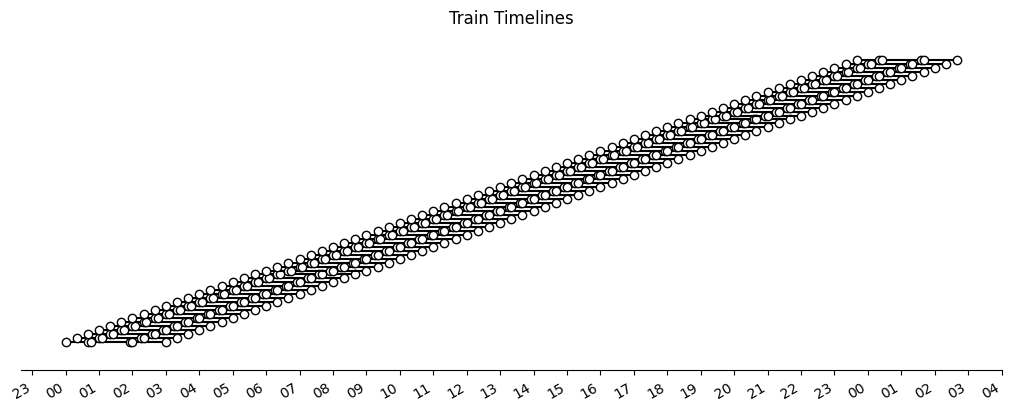

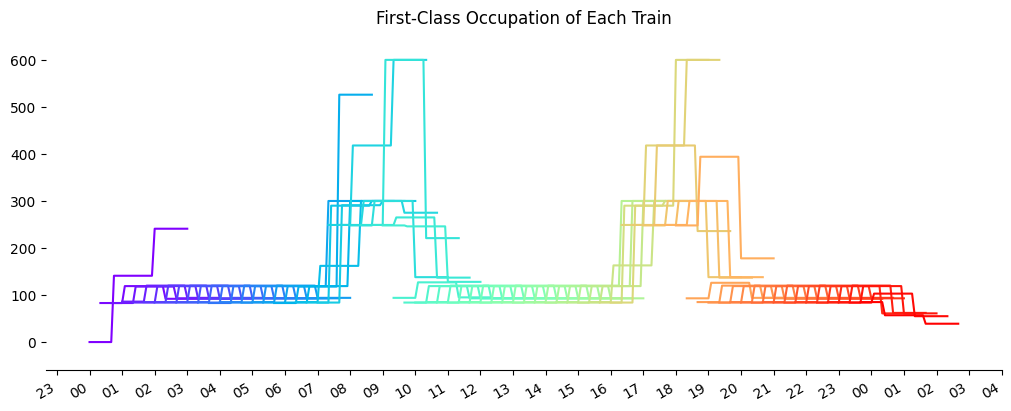

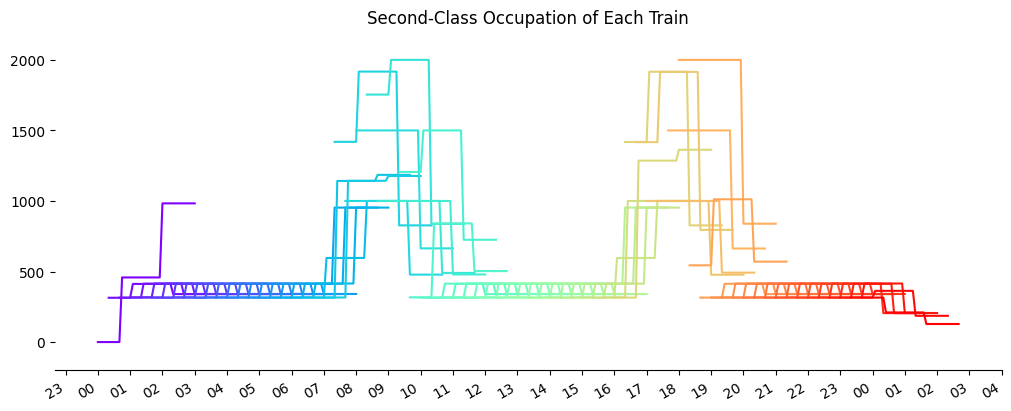

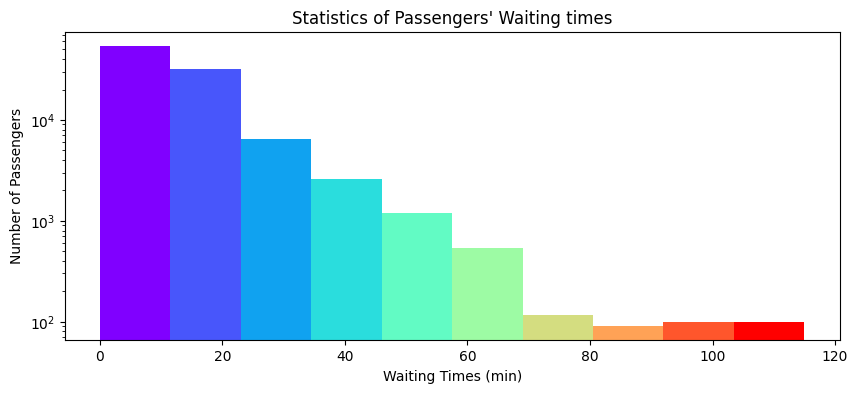

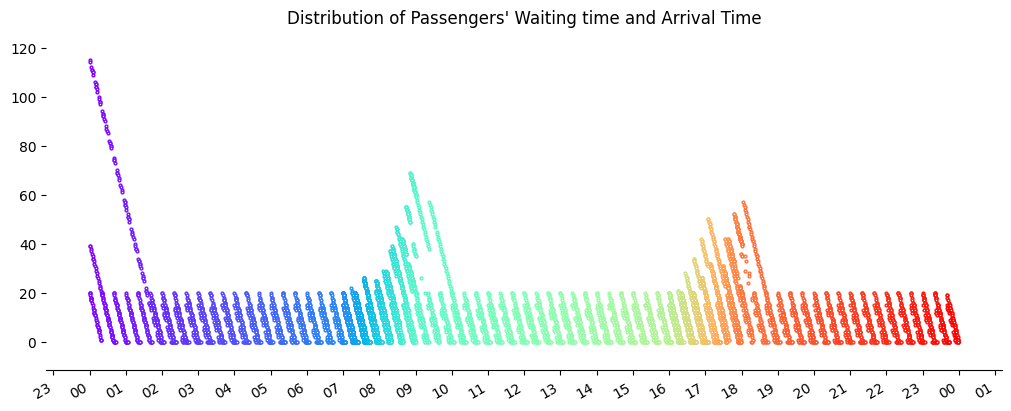

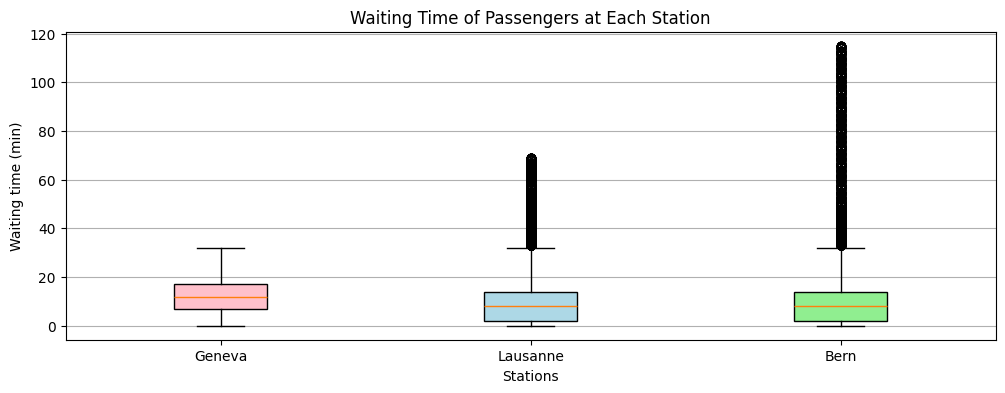

In [42]:
random.seed(42)
objective_function_choice = "cost"  # "waiting_time" or "cost"
_, initial_departure_times= constant_depart_nb_carriages_change()
initial_number_trains = len(initial_departure_times)
initial_carriage_configurations = random.choices(ALL_CARRIAGE_CONFIG[0:3], k=initial_number_trains) # configurations of the trains (number of carriages in first and second class)

initial_trains_schedule, initial_passengers = define_timeline(initial_carriage_configurations, initial_departure_times, initial_number_trains)
print(evaluate_cost(initial_trains_schedule, initial_passengers)/len(initial_passengers))
print(evaluate_waiting_time(initial_passengers)/len(initial_passengers))

plot_train_timelines(initial_trains_schedule, initial_passengers)
plot_first_carriages_occupation(initial_trains_schedule, initial_passengers)
plot_second_carriages_occupation(initial_trains_schedule, initial_passengers)

## Passenger Properties
plot_passenger_waiting_time(initial_trains_schedule, initial_passengers)
plot_passenger_waiting_time_per_arrival(initial_trains_schedule, initial_passengers) 
plot_passenger_waiting_time_per_station(initial_trains_schedule, initial_passengers)

9.168452899851289
15.55387827920363


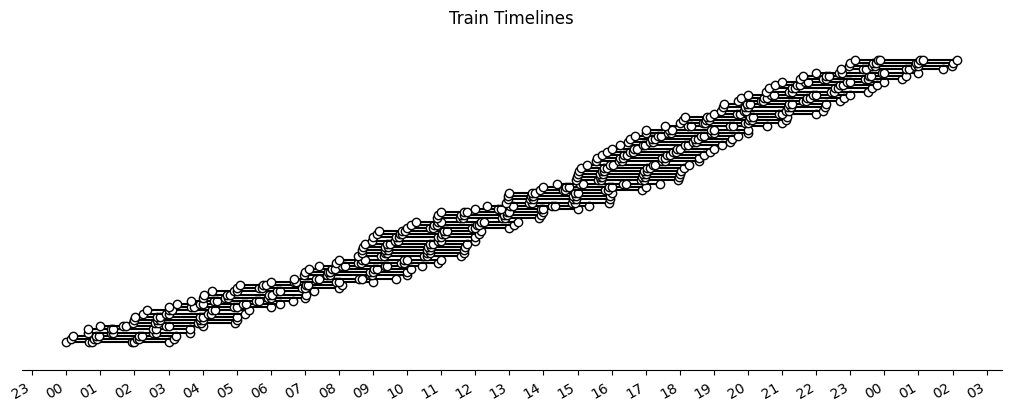

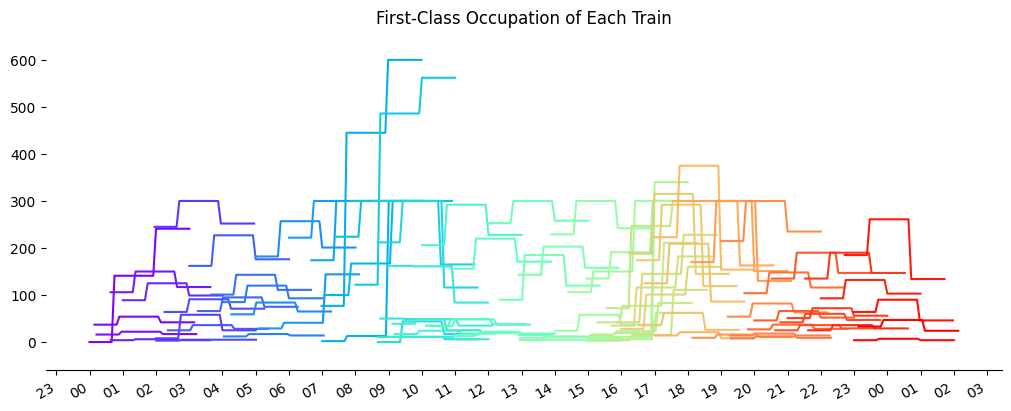

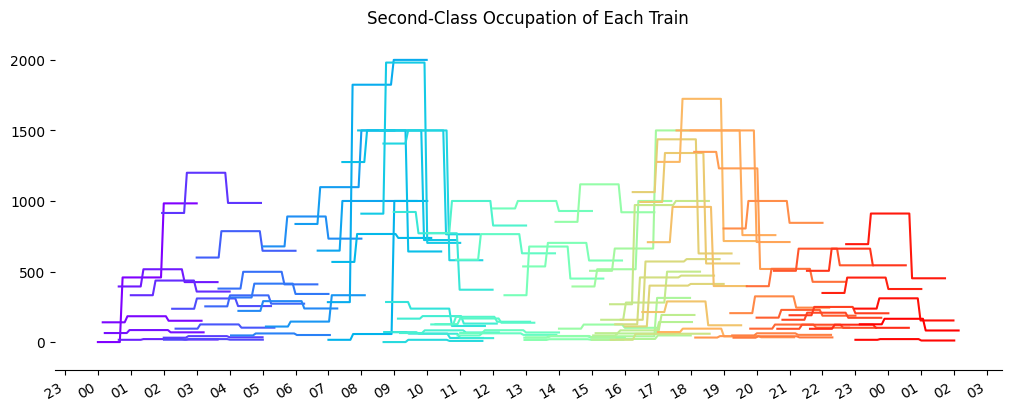

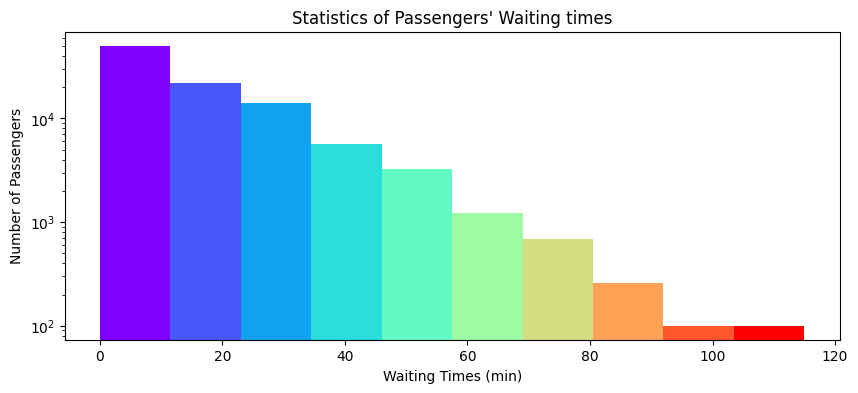

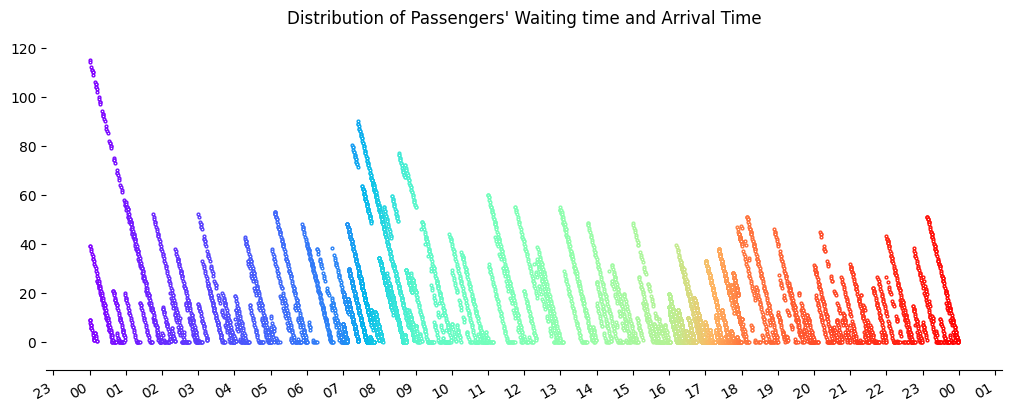

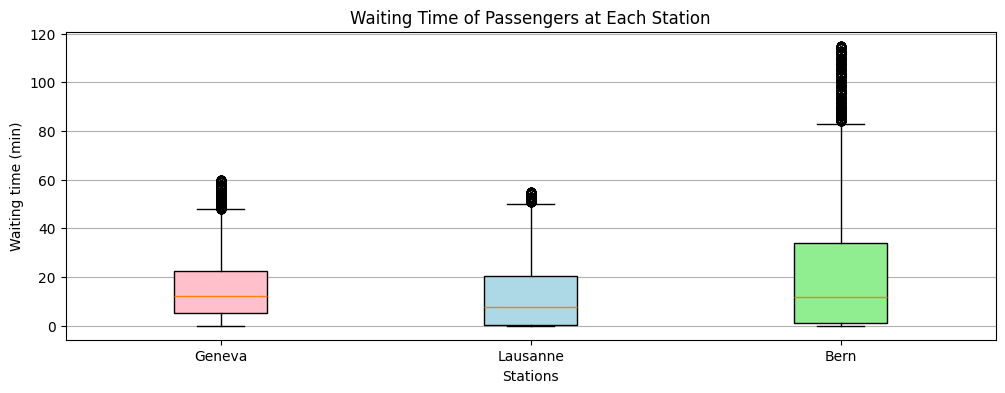

In [43]:
print(evaluate_cost(trains, best_passengers)/len(best_passengers))
print(evaluate_waiting_time(best_passengers)/len(best_passengers))
plot_train_timelines(trains, best_passengers)
plot_first_carriages_occupation(trains, best_passengers)
plot_second_carriages_occupation(trains, best_passengers)

## Passenger Properties
plot_passenger_waiting_time(trains, best_passengers)
plot_passenger_waiting_time_per_arrival(trains, best_passengers) 
plot_passenger_waiting_time_per_station(trains, best_passengers)

In [44]:
import plotly
import plotly.graph_objects as go


def draw_train_schedule(carriage_configurations_sol, departure_times_sol, title="Train Schedule"):
    """Function to visualize the train schedule and configurations."""
    fig = go.Figure()

    # Extract train departure times and configurations
    departure_times = [(departure_time-datetime(2000, 1, 1, hour=0)).total_seconds() / 3600 for departure_time in departure_times_sol]
    config_list = list(set(carriage_configurations_sol))
    configurations = [config_list.index(config) for config in carriage_configurations_sol]

    # Define configuration colors and labels
    config_colors = {0: 'blue', 1: 'green', 2: 'red'}
    if len(config_list) == 3:
        config_labels = {0: 'Config '+str(config_list[0]), 1: 'Config '+str(config_list[1]), 2: 'Config '+str(config_list[2])}
    elif len(config_list) == 2:
        config_labels = {0: 'Config '+str(config_list[0]), 1: 'Config '+str(config_list[1]), 2: 'Config 3'}
    else:
        config_labels = {0: 'Config '+str(config_list[0]), 1: 'Config 2', 2: 'Config 3'}

    # Create a scatter plot for each configuration, keeping lines intact
    for config in range(train_configurations):
        config_times = [departure_times[i] for i in range(len(configurations)) if configurations[i] == config]
        config_y = [configurations[i] for i in range(len(configurations)) if configurations[i] == config]
        
        # # Keep lines intact
        # fig.add_trace(go.Scatter(
        #     x=departure_times,
        #     y=configurations,
        #     mode='lines',
        #     line=dict(color='gray'),
        #     showlegend=False
        # ))

        if config_times:
            fig.add_trace(go.Scatter(
                x=config_times,
                y=config_y,
                mode='markers',
                name=config_labels[config],
                marker=dict(size=10, color=config_colors[config])
            ))
    
    fig.update_layout(
        title=title,
        xaxis_title='Departure Time (hours)',
        yaxis_title='Train Configuration',
        width=800,
        height=400,
        showlegend=True
    )
    
    fig.show()

# Example usage
# optimized_trains = your optimized train schedule dictionary
draw_train_schedule(optimized_trains[0], optimized_trains[1], title="Optimized Train Schedule")


#### Simulated Annealing

In [45]:
def temperature_update(max_t_changes, t_changes, avg_inc_obj, accep_init, accep_final):
    T_init = -avg_inc_obj / np.log(accep_init)
    T_final = -avg_inc_obj / np.log(accep_final)
    decay_rate = (T_final / T_init) ** (1 / max_t_changes)
    temperature = T_init * (decay_rate ** t_changes)
    return temperature


In [46]:
def simulated_annealing_trains(carriage_configurations, departure_times, trains_schedule, all_passengers, iterations=1000, display=False):
    max_t_changes = int(0.6 * iterations)
    avg_inc_obj = 0.1
    accep_init = 0.95
    accep_final = 0.00001
    
    T_init = temperature_update(max_t_changes, 0, avg_inc_obj, accep_init, accep_final)
    T_final = temperature_update(max_t_changes, max_t_changes, avg_inc_obj, accep_init, accep_final)
    decay_rate = (T_final / T_init) ** (1 / max_t_changes)
    print(f"Initial Temperature: {T_init} ℃")
    print(f"End Temperature: {T_final} ℃")
    print(f"Decay Rate: {decay_rate}\n\n")
    
    best_solution = (deepcopy(carriage_configurations), deepcopy(departure_times), deepcopy(trains_schedule))
    best_score = objective_function(trains_schedule, all_passengers, objective_function_choice)
    record_best_scores = []
    k = 0
    
    while k < max_t_changes:
        T = temperature_update(max_t_changes, k, avg_inc_obj, accep_init, accep_final)
        neighbors = neighborhood_trains(best_solution[0], best_solution[1], trains_schedule)
        
        for neighbor in neighbors:
            carriage_configurations_neighbor, departure_times_neighbor, number_trains_neighbor = neighbor
            trains_schedule_neighbor, all_passengers_neighbor = define_timeline(carriage_configurations_neighbor, departure_times_neighbor, number_trains_neighbor)
            current_score = objective_function(trains_schedule_neighbor, all_passengers_neighbor, objective_function_choice)
            delta = (current_score - best_score)
            
            if delta < 0 or np.exp(-delta / T) > np.random.rand():
                trains_schedule = trains_schedule_neighbor
                
                if current_score < best_score:
                    best_solution = neighbor
                    best_score = current_score
                    best_passengers = all_passengers_neighbor
                    trains_schedule = trains_schedule_neighbor
                    break  # Exit the inner loop for deeper local search
                
        if display:
            print(f"Iteration {k}: Best Score = {best_score}", end='\r')

        if objective_function_choice == 'waiting_time':
            record_best_scores.append(best_score)
        else:
            record_best_scores.append(best_score)
        
        k += 1
    
    return best_solution, best_score, record_best_scores, best_passengers, trains_schedule


In [47]:

# 运行模拟退火算法优化火车发车时间和车厢配置
# Run simulated annealing algorithm to optimize train departure times and car configurations
# Exécuter l'algorithme de recuit simulé pour optimiser les heures de départ des trains et les configurations de voiture
objective_function_choice = "waiting_time" 
optimized_trains, best_score, record_best_scores_SA, best_passenger, trains_schedule = simulated_annealing_trains(initial_carriage_configurations, initial_departure_times, initial_trains_schedule, all_passengers, iterations=50, display=True)

print("Optimized Train Schedules:", optimized_trains)
print("Best Score Achieved:", best_score)


Initial Temperature: 1.9495725746223673 ℃
End Temperature: 0.008685889638065039 ℃
Decay Rate: 0.8348898155829261


Optimized Train Schedules: ([(2, 4), (1, 2), (1, 2), (1, 2), (1, 3), (1, 3), (1, 3), (1, 2), (2, 4), (1, 2), (1, 2), (2, 4), (1, 2), (1, 2), (2, 4), (2, 4), (1, 2), (2, 4), (1, 3), (1, 2), (1, 3), (1, 3), (2, 4), (1, 2), (1, 3), (2, 4), (1, 2), (1, 2), (1, 3), (2, 4), (1, 3), (1, 3), (2, 4), (1, 3), (2, 4), (2, 4), (1, 3), (2, 4), (1, 3), (2, 4), (1, 3), (1, 2), (1, 2), (1, 2), (1, 2), (1, 2), (1, 2), (1, 2), (2, 4), (2, 4), (2, 4), (1, 2), (1, 2), (1, 3), (2, 4), (2, 4), (1, 2), (1, 3), (1, 2), (2, 4), (1, 3), (2, 4), (2, 4), (1, 3), (1, 3), (1, 3), (1, 2), (1, 2), (1, 2), (1, 2), (1, 2), (1, 3), (1, 2), (1, 3), (1, 2), (1, 3), (1, 3), (1, 2), (1, 2), (1, 3), (2, 4), (2, 4), (1, 3), (1, 3), (1, 2), (1, 3), (1, 2), (1, 3), (1, 2), (2, 4), (2, 4), (2, 4), (2, 4), (1, 3), (1, 2), (2, 4), (1, 3), (1, 2), (2, 4), (2, 4), (2, 4)], [Timestamp('2000-01-01 00:00:00'), Timestamp('2

15.231218911850675
9.37052307741996


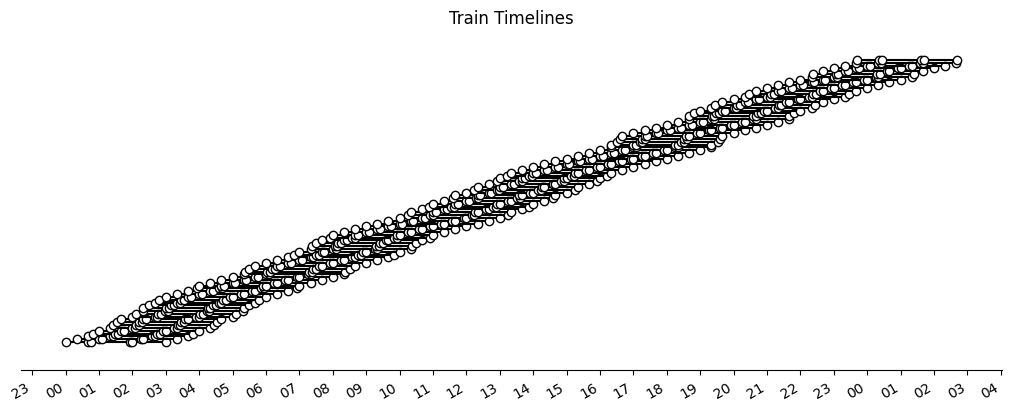

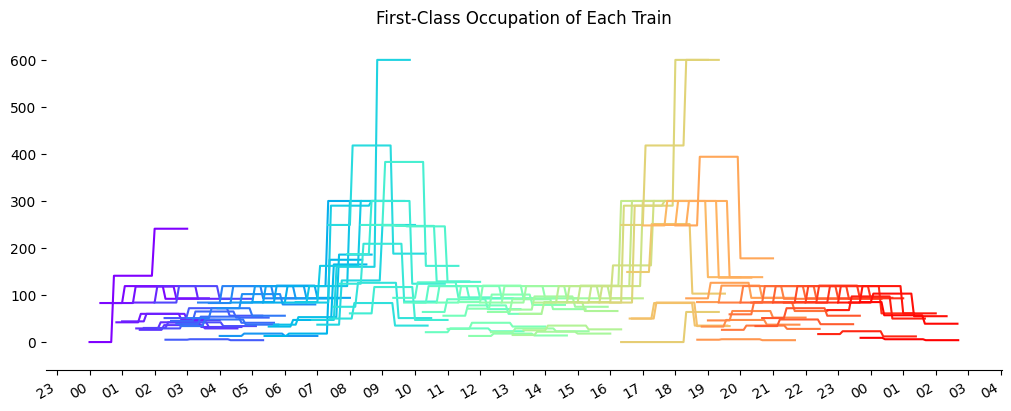

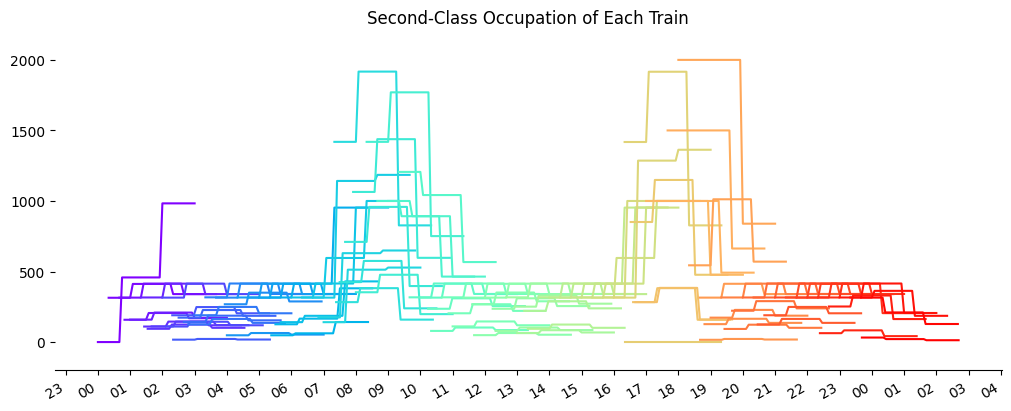

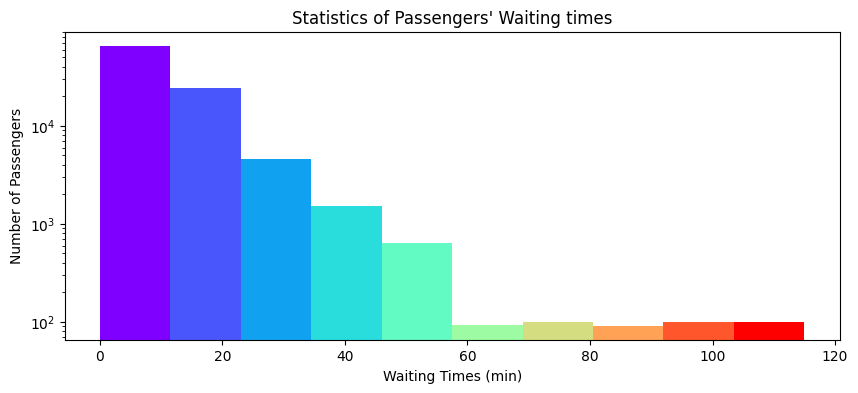

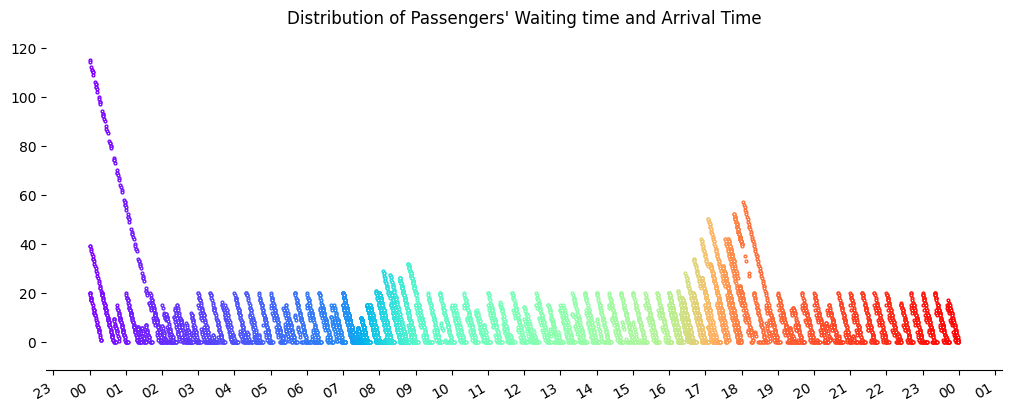

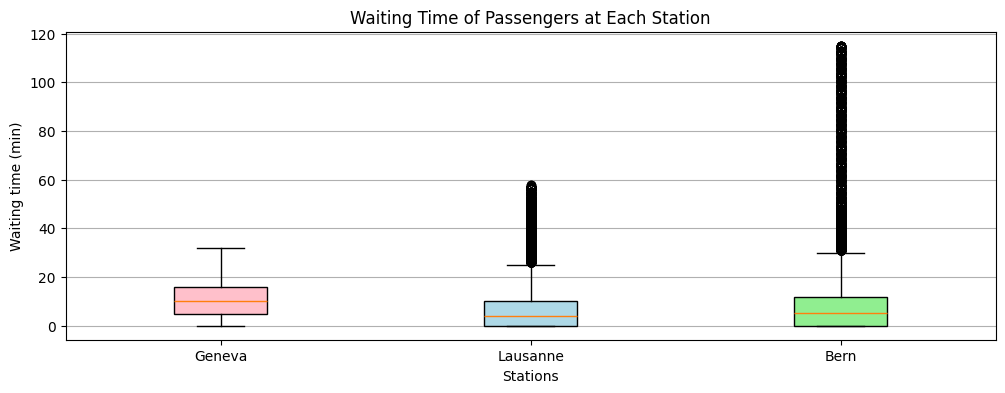

In [48]:
print(evaluate_cost(trains_schedule,best_passenger )/len(best_passengers))
print(evaluate_waiting_time(best_passenger)/len(best_passenger))
plot_train_timelines(trains_schedule, best_passenger)
plot_first_carriages_occupation(trains_schedule, best_passenger)
plot_second_carriages_occupation(trains_schedule, best_passenger)

## Passenger Properties
plot_passenger_waiting_time(trains_schedule, best_passenger)
plot_passenger_waiting_time_per_arrival(trains_schedule, best_passenger)
plot_passenger_waiting_time_per_station(trains_schedule, best_passenger)

In [49]:
# 可视化优化后的火车时间表和车厢配置
draw_train_schedule(optimized_trains[0], optimized_trains[1], title="Optimized Train Schedule")

#### Convergence comparison 

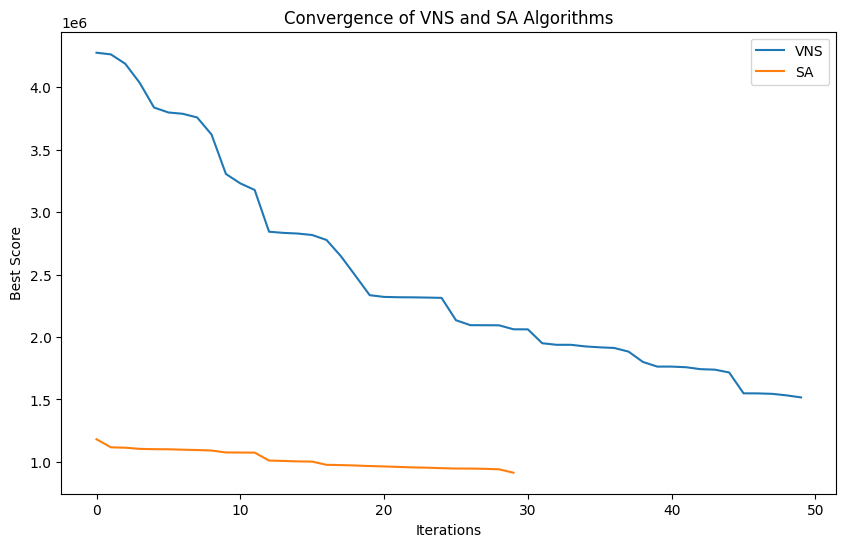

In [50]:
# Plot the convergence curve or VNS and SA algorithms
plt.figure(figsize=(10, 6))
plt.plot(record_best_scores_VNS, label="VNS")
plt.plot(record_best_scores_SA, label="SA")
plt.xlabel("Iterations")
plt.ylabel("Best Score")
plt.title("Convergence of VNS and SA Algorithms")
plt.legend()
plt.show()

We can see a better convergence for the Simulated annealing compared to the VNS. 

## Multi-Objective Optimization

To extend the single-objective optimization problem to a multi-objective optimization problem, we will build a Pareto front to show the trade-offs between our two objectives. For this purpose, we will use the Local Search for multi-objective problems based on the Dominance principle. 

In [51]:
#reminder of the initial solution 

train_configurations = 3
max_departure_hour = 24  # 一天中的小时数
# The number of hours in a day
# Le nombre d'heures dans une journée
ALL_CARRIAGE_CONFIG = [(1, 2), (1, 3), (1,4), (2, 2)] # all possible train configurations

def define_timeline(carriage_configurations, departure_times, number_trains):
    """Define all the trains and passengers with the decision variables"""
    trains_schedule = [Train(departure_times[i], carriage_configurations[i][0], carriage_configurations[i][1], [timedelta(minutes=5), timedelta(minutes=5)]) for i in range(number_trains)] # list of all trains
    all_passengers = constant_passenger_arrivals() # list of all passengers
    trains_passengers_management(all_passengers, trains_schedule)
    return trains_schedule, all_passengers


objective_function_choice = "cost"  # "waiting_time" or "cost"
_, initial_departure_times= constant_depart_nb_carriages_change()
initial_number_trains = len(initial_departure_times)
initial_carriage_configurations = random.choices(ALL_CARRIAGE_CONFIG[0:3], k=initial_number_trains) # configurations of the trains (number of carriages in first and second class)

initial_trains_schedule, initial_passengers = define_timeline(initial_carriage_configurations, initial_departure_times, initial_number_trains)

In [60]:
def dominance(cost_x1, cost_x2):
    """Determines dominance between two solutions based on their cost components with respect to two objectives.

    Args:
        cost_x1 (list): a list of cost components with respect to objectives f_1 and f_2 for solution x1.
        cost_x2 (list): a list of cost components with respect to objectives f_1 and f_2 for solution x2.
        
    Returns:
        bool: True if solution x1 dominates solution x2, False otherwise.
        
    Examples:
        >>> dominance([105, 1.58], [99, 2.25])
        True
        >>> dominance([105, 1.58], [99, 1.45])
        False
    """ 
    
    # Implement your solution here
    return (cost_x1[0] <= cost_x2[0] and cost_x1[1] <= cost_x2[1]) and (cost_x1[0] < cost_x2[0] or cost_x1[1] < cost_x2[1])

def generate_D_and_S(P, cost_new):
    
    """Generates sets of solutions dominated and dominating a new neighbor solution within a Pareto set.

    Args:
        P (dict): a dictionary containing solutions in a Pareto set.
        cost_new (list): a list of cost components with respect to objectives f_1 and f_2 for a new neighbor 
        solution.

    Returns:
        D (dict): A set of solutions in P dominated by the new neighbor solution.
        S (dict): A set of solutions in P that dominate the new neighbor solution.
        
    """ 
        
    D = {}
    S = {}
    
    # Implement your solution here
    for sol, costs in P.items():
        if dominance(cost_new, costs):
            D[sol] = costs
        elif dominance(costs, cost_new):
            S[sol] = costs

    return D,S

In [61]:
def neighbor_sol(carriage_configurations, departure_times, trains_schedule):
    """We define in this function the neighborhood of our solutions. 
       The neighborhood is defined by n neighbors
       A neighbor can be defined by: 
        - adding or removing a train
        - changing the configuration of one or more train(s)
        - changing the departure time of one or more train(s)"""
    sol_carriage_configurations = list(deepcopy(carriage_configurations))
    # print("sol carriage configurations", sol_carriage_configurations)
    sol_departure_times = list(deepcopy(departure_times))
    sol_trains_schedule = list(deepcopy(trains_schedule))
    number_trains = len(sol_trains_schedule)

    respect_constraints = False
    while not respect_constraints:
        # start from initial schedule
        carriage_configurations = deepcopy(sol_carriage_configurations)
        departure_times = deepcopy(sol_departure_times)
        trains_schedule = deepcopy(sol_trains_schedule)
        number_trains = len(trains_schedule)
        # we add or remove one train to the schedule with probability 0.5

        if np.random.uniform(0, 1) > 0.5:
            hazard = np.random.choice([-1, 1], 1)
            if hazard == 1:
                # add randomly one train
                number_trains += 1
                departure_times.append(datetime(2000, 1, 1, hour=0) + timedelta(hours=np.random.uniform(0,24)))
                carriage_configurations.append(random.sample(ALL_CARRIAGE_CONFIG, 1)[0])
            else: 
                if number_trains == 0:
                    number_trains = 1
                else:
                    # remove randomly one train 
                    number_trains -= 1
                    idx = np.random.choice(range(len(trains_schedule)), 1)[0]
                    del trains_schedule[idx]
                    del departure_times[idx]
                    del carriage_configurations[idx]
        # we change the configuration of one or more trains with probability +/nb_trains for each train 
        for i in range(number_trains):
            if np.random.uniform(0, 1) < 1/number_trains:
                carriage_configurations[i] = random.sample(ALL_CARRIAGE_CONFIG, 1)[0]
        
        # we change the departure time of one or more trains with probability +/nb_trains for each train (+ or - 10mins)
        for i in range(number_trains):
            if np.random.uniform(0, 1) < 1/number_trains:
                departure_times[i] = departure_times[i] + timedelta(minutes=int(np.random.choice([-10, 10], 1)[0]))
        
        # check if the constraints are respected
        
        respect_constraints = check_constraints(carriage_configurations, departure_times, number_trains)
            
    return (carriage_configurations, departure_times, number_trains)

In [62]:
from numpy.random import Generator, PCG64 

def main(initial_trains_schedule, initial_carriage_configurations, initial_departure_times, initial_number_trains, all_passengers, iterations=100):
    """Main function to solve the bi-objective problem using the VNS algorithm.

    Args:

        iterations (int): maximum number of iterations of the algorithm
        W (int): maximum weight of the knapsack.

    Returns:
        P (dict): a dictionary containing solutions in a Pareto set.
        D_all (dict): a dictionary containing all dominated solutions.
        
    """ 
    
    P = {}
    D_all = {}
    rg = Generator(PCG64(42069))
    
    initial_cost = [objective_function(initial_trains_schedule, all_passengers, "waiting_time"), 
                    objective_function(initial_trains_schedule, all_passengers, "cost")]
    P[tuple([tuple(initial_carriage_configurations), tuple(initial_departure_times), initial_number_trains])] = initial_cost
    
    for it in range(iterations):
        # Select a random solution from P
        keys = list(P.keys())
        selected_index = rg.choice(len(keys))
        current_solution = list(keys[selected_index])
        trains_schedule_current, all_passengers_current = define_timeline(current_solution[0], current_solution[1], current_solution[2])
        
        # Generate a neighbor
        neighbor_solution  = neighbor_sol(current_solution[0], current_solution[1], trains_schedule_current)
        carriage_configurations_neighbor, departure_times_neighbor, number_trains_neighbor = neighbor_solution
        trains_schedule_neighbor, all_passengers_neighbor = define_timeline(carriage_configurations_neighbor, departure_times_neighbor, number_trains_neighbor)

        
        # Compute the new cost of the new solution(s)
        neighbor_cost = [objective_function(trains_schedule_neighbor, all_passengers_neighbor, "waiting_time"), 
                         objective_function(trains_schedule_neighbor, all_passengers_neighbor, "cost")]
        
        # Apply Pareto dominance, i.e., sets D and S
        D, S = generate_D_and_S(P, neighbor_cost)

        # If S is empty, update P
        if not S:
            for sol in D:
                del P[sol]
            P[tuple([tuple(carriage_configurations_neighbor), tuple(departure_times_neighbor), number_trains_neighbor])] = neighbor_cost
            D_all.update(D)
        
        print(f"Iteration {it}: Number of solutions in P = {len(P)}")
    
    return P, D_all

## Run the multi-objective optimization 

In [66]:
P, D_all = main(initial_trains_schedule, initial_carriage_configurations, initial_departure_times, initial_number_trains, all_passengers, iterations=20)

Iteration 0: Number of solutions in P = 1
Iteration 1: Number of solutions in P = 2
Iteration 2: Number of solutions in P = 2
Iteration 3: Number of solutions in P = 2
Iteration 4: Number of solutions in P = 2
Iteration 5: Number of solutions in P = 3
Iteration 6: Number of solutions in P = 4
Iteration 7: Number of solutions in P = 4
Iteration 8: Number of solutions in P = 4
Iteration 9: Number of solutions in P = 4
Iteration 10: Number of solutions in P = 4
Iteration 11: Number of solutions in P = 5
Iteration 12: Number of solutions in P = 5
Iteration 13: Number of solutions in P = 6
Iteration 14: Number of solutions in P = 7
Iteration 15: Number of solutions in P = 3
Iteration 16: Number of solutions in P = 3
Iteration 17: Number of solutions in P = 3
Iteration 18: Number of solutions in P = 3
Iteration 19: Number of solutions in P = 3


### View the Pareto front

In [70]:
def draw_pareto_frontier(P, D_all):
    costs_P = []
    utilities_P = []
    costs_D = []
    utilities_D = []

    for sol, cost in P.items():
        utilities_P.append(cost[0])
        costs_P.append(cost[1])

    for sol, cost in D_all.items():
        utilities_D.append(cost[0])
        costs_D.append(cost[1])

    trace_P = go.Scatter(x=utilities_P, y=costs_P, mode='markers', name='Non-dominated')
    trace_D = go.Scatter(x=utilities_D, y=costs_D, mode='markers', name='Dominated', marker=dict(symbol='x'))

    layout = go.Layout(
        template="presentation",
        xaxis=dict(title='total waiting time (minutes)'),
        yaxis=dict(title='Cost'),
        legend=dict(x=0, y=1),
        width=800, 
        height=600
    )

    fig = go.Figure(data=[trace_P, trace_D], layout=layout)
    fig.show()

In [71]:
draw_pareto_frontier(P, D_all)